2025-05-02 07:54:44,791 - predictive_policing - INFO - Starting ethical predictive policing pipeline
INFO:predictive_policing:Starting ethical predictive policing pipeline
2025-05-02 07:54:44,792 - predictive_policing - INFO - Loading datasets (full_dataset=False, years=[2018, 2019, 2020, 2021, 2022, 2023, 2024])...
INFO:predictive_policing:Loading datasets (full_dataset=False, years=[2018, 2019, 2020, 2021, 2022, 2023, 2024])...
2025-05-02 07:54:44,794 - predictive_policing - INFO - Loading Chicago crime data from cache
INFO:predictive_policing:Loading Chicago crime data from cache


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2025-05-02 07:55:02,219 - predictive_policing - INFO - Filtered to years [2018, 2019, 2020, 2021, 2022, 2023, 2024]: 0 records
INFO:predictive_policing:Filtered to years [2018, 2019, 2020, 2021, 2022, 2023, 2024]: 0 records
2025-05-02 07:55:02,221 - predictive_policing - INFO - Loaded 0 records from cache
INFO:predictive_policing:Loaded 0 records from cache
2025-05-02 07:55:02,222 - predictive_policing - WARNING - Crime data cache is empty, fetching from API directly
2025-05-02 07:55:03,301 - predictive_policing - INFO - Fetching Chicago crime data from API with year filter: &$where=year=2018 OR year=2019 OR year=2020 OR year=2021 OR year=2022 OR year=2023 OR year=2024
INFO:predictive_policing:Fetching Chicago crime data from API with year filter: &$where=year=2018 OR year=2019 OR year=2020 OR year=2021 OR year=2022 OR year=2023 OR year=2024


Fetching Chicago Crime Data:   0%|          | 0/100000 [00:00<?, ?rec/s]

2025-05-02 07:55:55,656 - predictive_policing - INFO - Fetched 100,000 Chicago crime records from API
INFO:predictive_policing:Fetched 100,000 Chicago crime records from API
2025-05-02 07:55:58,449 - predictive_policing - INFO - Crime data shape: (100000, 22)
INFO:predictive_policing:Crime data shape: (100000, 22)
2025-05-02 07:55:58,450 - predictive_policing - INFO - Community data shape: (77, 6)
INFO:predictive_policing:Community data shape: (77, 6)
2025-05-02 07:55:58,451 - predictive_policing - INFO - Census data shape: (78, 9)
INFO:predictive_policing:Census data shape: (78, 9)
2025-05-02 07:55:58,453 - predictive_policing - INFO - Cleaning all datasets...
INFO:predictive_policing:Cleaning all datasets...
2025-05-02 07:55:58,454 - predictive_policing - INFO - Cleaning dataframe...
INFO:predictive_policing:Cleaning dataframe...
2025-05-02 07:56:00,552 - predictive_policing - INFO - Cleaning dataframe...
INFO:predictive_policing:Cleaning dataframe...
2025-05-02 07:56:00,652 - predic

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


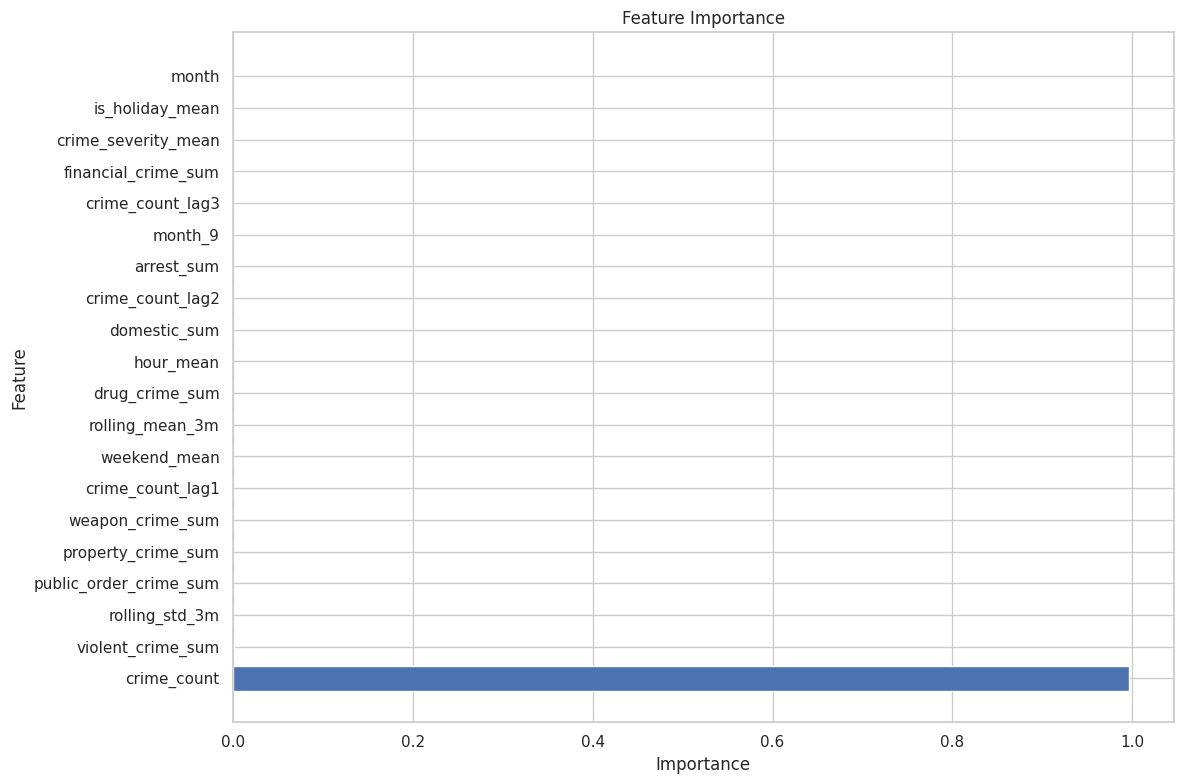

<Figure size 1400x1000 with 0 Axes>

Error in callback <function flush_figures at 0x7a281c69cae0> (for post_execute):


KeyboardInterrupt: 

In [22]:
"""
Ethical and Parallelized Predictive Policing System

This implementation combines fairness-aware AI, model explainability,
and parallelization techniques for ethical crime prediction.

Key components:
1. Data processing with parallelization (OpenMP/multiprocessing)
2. Fairness-aware model training with adversarial debiasing
3. Model explainability with SHAP and LIME
4. Ethical warning system for bias detection
5. Visualization dashboard

Authors: Sai Rishi Kiran Mannava, Venkata Akash Reddy Kakunuri, Anthony Kwasi
"""

import os
import gc
import time
import json
import logging
import warnings
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count

# ML libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

# For working with large datasets
try:
    import dask.dataframe as dd
    DASK_AVAILABLE = True
except ImportError:
    DASK_AVAILABLE = False

# For model explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False

# For fairness-aware AI
try:
    import tensorflow as tf
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False

try:
    import aif360
    from aif360.algorithms.preprocessing import Reweighing
    from aif360.datasets import BinaryLabelDataset
    AIF360_AVAILABLE = True
except ImportError:
    AIF360_AVAILABLE = False

# For GPU acceleration
try:
    import cupy as cp
    CUPY_AVAILABLE = True
except ImportError:
    CUPY_AVAILABLE = False

# For web dashboard
try:
    from flask import Flask, render_template, request, jsonify
    FLASK_AVAILABLE = True
except ImportError:
    FLASK_AVAILABLE = False

# Import for Google Colab if available
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configure warning handling
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ---------------------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------------------
class Config:
    def __init__(self):
        # Set base directory based on environment
        if IN_COLAB:
            # Mount Google Drive in Colab
            drive.mount('/content/drive')
            self.base_dir = "/content/drive/MyDrive/predictive_policing"
        else:
            # Use current directory if not in Colab
            self.base_dir = os.path.join(os.getcwd(), "predictive_policing")

        # Define subdirectories
        self.data_dir = os.path.join(self.base_dir, "data")
        self.results_dir = os.path.join(self.base_dir, "results")
        self.logs_dir = os.path.join(self.base_dir, "logs")
        self.cache_dir = os.path.join(self.base_dir, "cache")
        self.viz_dir = os.path.join(self.results_dir, "visualizations")
        self.models_dir = os.path.join(self.base_dir, "models")
        self.templates_dir = os.path.join(self.base_dir, "templates")

        # Create directories
        for directory in [self.base_dir, self.data_dir, self.results_dir, self.logs_dir,
                          self.cache_dir, self.viz_dir, self.models_dir, self.templates_dir]:
            os.makedirs(directory, exist_ok=True)

        # Data loading parameters
        self.max_crime_records = 10000000
        self.batch_size = 1000000
        self.use_caching = True
        self.use_dask = DASK_AVAILABLE
        self.chunk_size = 500000

        # Parallelization settings
        self.use_parallel = True
        self.num_workers = cpu_count()
        self.use_gpu = CUPY_AVAILABLE

        # Time period for analysis
        self.years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
        self.time_split_method = 'by_year'  # 'by_year' or 'random'

        # Model parameters
        self.random_state = 42
        self.test_size = 0.2
        self.cv_folds = 5
        self.target = "crime_count"
        self.stratify_target = False
        self.scale_features = True
        self.feature_selection = True
        self.imputation_strategy = 'median'
        self.max_features = 30  # Added to fix the missing attribute error

        # Fairness settings
        self.fairness_threshold = 0.8
        self.reporting_bias_correction = True
        self.use_adversarial_debiasing = TF_AVAILABLE
        self.use_reweighting = AIF360_AVAILABLE
        self.debiasing_protected_attrs = ['hardship_index', 'per_capita_income', 'pct_poverty']

        # Protected attributes for fairness analysis
        self.protected_attributes = [
            "hardship_index", "per_capita_income", "pct_poverty",
            "pct_unemployed", "pct_no_hs_diploma", "pct_housing_crowded",
            "percent_aged_16_unemployed", "percent_aged_25_without_high_school_diploma",
            "percent_households_below_poverty", "per_capita_income",
            "socioeconomic_score"
        ]

        # Explainability settings
        self.use_shap = SHAP_AVAILABLE
        self.use_lime = LIME_AVAILABLE
        self.num_features_explain = 10

        # Performance metrics
        self.metrics = ["r2", "rmse", "mae", "mape"]

        # Uncertainty quantification parameters
        self.enable_uncertainty = True
        self.prediction_intervals = True
        self.bootstrap_samples = 50

        # Hyperparameter tuning
        self.hyperparameter_tuning = True
        self.hyperparameter_method = "random"  # 'random' or 'bayesian'
        self.n_hyperopt_evals = 50

        # API endpoints
        self.chicago_crime_api = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
        self.chicago_community_api = "https://data.cityofchicago.org/resource/igwz-8jzy.json"
        self.chicago_census_api = "https://data.cityofchicago.org/resource/kn9c-c2s2.json"
        self.api_timeout = 120
        self.api_retries = 3
        self.api_backoff = 2

        # Dashboard settings
        self.enable_dashboard = FLASK_AVAILABLE
        self.dashboard_port = 5000
        self.dashboard_host = "127.0.0.1"

        # Column mapping for standardization
        self.column_mapping = {
            "community_area": "community_area",
            "block": "block",
            "area_numbe": "community_area_id",
            "area_number": "community_area_id",
            "community": "community_name",
            "communityname": "community_name",
            "per_capita_income": "per_capita_income",
            "hardship_index": "hardship_index",
            "percent_households_below_poverty": "pct_poverty",
            "percent_aged_16_unemployed": "pct_unemployed",
            "percent_aged_25_without_high_school_diploma": "pct_no_hs_diploma",
            "percent_housing_crowded": "pct_housing_crowded",
            "ca": "community_area",
            "community_area_name": "community_name"
        }

# Global configuration
CONFIG = Config()

# ---------------------------------------------------------------------
# LOGGER SETUP
# ---------------------------------------------------------------------
def setup_logger():
    """Set up and configure the logging system"""
    logger = logging.getLogger("predictive_policing")
    if logger.handlers:
        return logger

    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Console handler
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(formatter)
    logger.addHandler(ch)

    # File handler
    log_file = os.path.join(CONFIG.logs_dir, f"pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    return logger

logger = setup_logger()

# ---------------------------------------------------------------------
# MEMORY MANAGEMENT
# ---------------------------------------------------------------------
def clear_memory():
    """Force garbage collection to free memory"""
    gc.collect()

def log_memory_usage():
    """Log current memory usage"""
    try:
        import psutil
        process = psutil.Process(os.getpid())
        memory_mb = process.memory_info().rss / (1024 * 1024)
        logger.info(f"Current memory usage: {memory_mb:.2f} MB")
    except ImportError:
        logger.warning("psutil not available, skipping memory usage logging")

# ---------------------------------------------------------------------
# PARALLELIZATION UTILITIES
# ---------------------------------------------------------------------
def parallelize_dataframe(df, func, n_cores=None):
    """
    Parallelize operations on a dataframe using Python's multiprocessing

    Args:
        df: Pandas DataFrame to process
        func: Function to apply to each chunk
        n_cores: Number of CPU cores to use (defaults to all available)

    Returns:
        Processed DataFrame
    """
    if n_cores is None:
        n_cores = CONFIG.num_workers

    # Ensure we don't create more partitions than we have rows
    n_cores = min(n_cores, len(df))

    if n_cores <= 1:
        return func(df)

    logger.info(f"Parallelizing dataframe processing with {n_cores} cores")

    # Split dataframe into chunks
    df_split = np.array_split(df, n_cores)

    # Process in parallel
    with Pool(n_cores) as pool:
        df_list = pool.map(func, df_split)

    # Combine results
    return pd.concat(df_list)

def process_data_in_chunks_parallel(df, chunk_size=None, processor_func=None):
    """
    Process a large dataframe in chunks with parallelization

    Args:
        df: DataFrame to process
        chunk_size: Size of each chunk
        processor_func: Function to apply to each chunk

    Returns:
        Processed DataFrame
    """
    if df is None or processor_func is None:
        return df

    if chunk_size is None:
        chunk_size = CONFIG.chunk_size

    # If DataFrame is small enough, process directly with parallelization
    if len(df) <= chunk_size:
        return parallelize_dataframe(df, processor_func)

    # For larger DataFrames, process in chunks
    n_chunks = (len(df) + chunk_size - 1) // chunk_size
    logger.info(f"Processing dataframe in {n_chunks} chunks with parallelization")

    results = []
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))

        logger.info(f"Processing chunk {i+1}/{n_chunks} (rows {start_idx}-{end_idx})")
        chunk = df.iloc[start_idx:end_idx].copy()

        # Process chunk with parallelization
        processed_chunk = parallelize_dataframe(chunk, processor_func)
        results.append(processed_chunk)

        # Clear memory
        del chunk
        clear_memory()

    # Combine results
    if results:
        if isinstance(results[0], pd.DataFrame):
            try:
                return pd.concat(results, ignore_index=True)
            except Exception as e:
                logger.error(f"Error concatenating chunks: {e}")
                return results
        else:
            return results
    return None

def process_with_dask(df, processor_func=None, npartitions=None):
    """
    Process data using Dask for better memory usage with large datasets

    Args:
        df: DataFrame to process
        processor_func: Function to apply to each partition
        npartitions: Number of partitions to use

    Returns:
        Processed DataFrame
    """
    if df is None or processor_func is None or not DASK_AVAILABLE:
        if not DASK_AVAILABLE:
            logger.warning("Dask not available, falling back to chunk processing")
        return process_data_in_chunks_parallel(df, processor_func=processor_func)

    # Determine number of partitions based on data size
    if npartitions is None:
        npartitions = max(1, len(df) // CONFIG.chunk_size)

    logger.info(f"Processing with Dask using {npartitions} partitions")

    try:
        # Convert to Dask DataFrame
        ddf = dd.from_pandas(df, npartitions=npartitions)

        # Apply processing function
        result_ddf = ddf.map_partitions(processor_func)

        # Convert back to pandas
        result = result_ddf.compute()
        logger.info(f"Dask processing complete, result shape: {result.shape}")
        return result
    except Exception as e:
        logger.error(f"Error in Dask processing: {e}")
        # Fallback to chunk processing
        logger.info("Falling back to chunk processing")
        return process_data_in_chunks_parallel(df, processor_func=processor_func)

def gpu_accelerate(X_data, function_to_apply):
    """
    Apply GPU acceleration to numerical operations if CUDA is available

    Args:
        X_data: NumPy array to process
        function_to_apply: Function to apply using GPU

    Returns:
        Processed data
    """
    if not CONFIG.use_gpu or not CUPY_AVAILABLE:
        # Fall back to CPU
        return function_to_apply(X_data)

    try:
        # Transfer data to GPU
        X_gpu = cp.array(X_data)

        # Apply function on GPU
        result_gpu = function_to_apply(X_gpu)

        # Transfer results back to CPU
        result = cp.asnumpy(result_gpu)

        # Free GPU memory
        del X_gpu, result_gpu
        cp.get_default_memory_pool().free_all_blocks()

        return result
    except Exception as e:
        logger.error(f"Error in GPU processing: {e}")
        # Fall back to CPU
        return function_to_apply(X_data)

# ---------------------------------------------------------------------
# DATA HELPERS
# ---------------------------------------------------------------------
def standardize_columns(df, mapping):
    """
    Standardize column names using mapping dictionary
    """
    if df is None or len(df) == 0:
        return df

    # Apply mapping only for columns that exist in the DataFrame
    rename_dict = {k: v for k, v in mapping.items() if k in df.columns}
    if rename_dict:
        df = df.rename(columns=rename_dict)

    # Standardize all column names (lowercase and strip whitespace)
    df.columns = df.columns.str.lower().str.strip()

    return df

def convert_numeric_columns(df, cols):
    """
    Convert specified columns to numeric type
    """
    if df is None or len(df) == 0:
        return df

    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

def downcast_dtypes(df):
    """
    Optimize memory usage by downcasting numeric types
    """
    if df is None or len(df) == 0:
        return df

    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    # Downcast float columns
    float_cols = result.select_dtypes(include=["float"]).columns
    for col in float_cols:
        result[col] = pd.to_numeric(result[col], downcast="float")

    # Downcast integer columns
    int_cols = result.select_dtypes(include=["int"]).columns
    for col in int_cols:
        result[col] = pd.to_numeric(result[col], downcast="integer")

    return result

def handle_null_values(df, numeric_strategy='median', categorical_strategy='most_frequent'):
    """
    Handle missing values with configurable strategies
    """
    if df is None or len(df) == 0:
        return df

    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    # Handle numeric columns
    num_cols = result.select_dtypes(include=['int', 'float']).columns
    for col in num_cols:
        if result[col].isnull().sum() > 0:
            if numeric_strategy == 'median':
                result[col] = result[col].fillna(result[col].median())
            elif numeric_strategy == 'mean':
                result[col] = result[col].fillna(result[col].mean())
            elif numeric_strategy == 'zero':
                result[col] = result[col].fillna(0)

    # Handle categorical columns
    cat_cols = result.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if result[col].isnull().sum() > 0:
            if categorical_strategy == 'most_frequent':
                most_freq = result[col].mode()[0] if not result[col].mode().empty else "Unknown"
                result[col] = result[col].fillna(most_freq)
            elif categorical_strategy == 'new_category':
                result[col] = result[col].fillna("Unknown")

    return result

# ---------------------------------------------------------------------
# DATA LOADING WITH CACHING AND CHUNKING FOR LARGE DATASETS
# ---------------------------------------------------------------------
def make_api_request(url, timeout=None, max_retries=None, backoff_factor=None):
    """
    Make an API request with retry logic
    """
    # Use config defaults if not specified
    timeout = timeout if timeout is not None else CONFIG.api_timeout
    max_retries = max_retries if max_retries is not None else CONFIG.api_retries
    backoff_factor = backoff_factor if backoff_factor is not None else CONFIG.api_backoff

    for attempt in range(max_retries):
        try:
            resp = requests.get(url, timeout=timeout)
            resp.raise_for_status()
            return resp.json()
        except requests.exceptions.RequestException as e:
            wait_time = backoff_factor ** attempt
            logger.warning(f"Request failed (attempt {attempt+1}/{max_retries}): {e}")
            logger.info(f"Waiting {wait_time:.1f} seconds before retry...")

            if attempt < max_retries - 1:
                time.sleep(wait_time)
            else:
                logger.error(f"Max retries exceeded for URL: {url}")
                return None

def fetch_sample_crime_data():
    """Generate sample crime data when API fails"""
    logger.info("Generating synthetic sample crime data for testing")

    # Create a sample DataFrame with expected columns
    sample_size = 10000
    np.random.seed(CONFIG.random_state)

    # Generate dates within the specified years
    start_date = datetime(min(CONFIG.years), 1, 1)
    end_date = datetime(max(CONFIG.years), 12, 31)
    days_range = (end_date - start_date).days

    # Generate random dates
    random_days = np.random.randint(0, days_range, sample_size)
    dates = [start_date + timedelta(days=days) for days in random_days]

    # Generate community areas (1-77)
    community_areas = np.random.randint(1, 78, sample_size).astype(str)

    # Generate crime types
    crime_types = np.random.choice(
        ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'BURGLARY',
         'NARCOTICS', 'ROBBERY', 'MOTOR VEHICLE THEFT', 'HOMICIDE'],
        sample_size,
        p=[0.3, 0.2, 0.15, 0.1, 0.08, 0.07, 0.05, 0.04, 0.01]
    )

    # Generate arrests (boolean)
    arrests = np.random.choice([True, False], sample_size, p=[0.2, 0.8])

    # Create DataFrame
    df = pd.DataFrame({
        'id': [f"sample_{i}" for i in range(sample_size)],
        'case_number': [f"HZ{100000+i}" for i in range(sample_size)],
        'date': dates,
        'block': [f"{np.random.randint(1, 9999)} BLOCK SAMPLE ST" for _ in range(sample_size)],
        'primary_type': crime_types,
        'community_area': community_areas,
        'arrest': arrests,
        'year': [d.year for d in dates],
        'latitude': np.random.uniform(41.6, 42.1, sample_size),
        'longitude': np.random.uniform(-87.9, -87.5, sample_size)
    })

    # Add date-derived fields
    df['month'] = df['date'].dt.month

    logger.info(f"Generated {len(df)} sample crime records")
    return df

def fetch_chicago_crime_data(use_cache=True, use_full_dataset=True, years=None):
    """
    Fetch Chicago crime data with caching and year filtering
    """
    cache_file = os.path.join(CONFIG.cache_dir, "chicago_crime_data.parquet")

    # Try to load from cache first
    if use_cache and os.path.exists(cache_file):
        try:
            logger.info(f"Loading Chicago crime data from cache")
            df = pd.read_parquet(cache_file)

            # Check if the cache is empty or has too few records
            if df is None or len(df) < 100:
                logger.warning(f"Cache appears to be empty or has too few records ({len(df)}), fetching from API")
                use_cache = False
            else:
                # Apply year filter if specified
                if years is not None and 'year' in df.columns:
                    df = df[df['year'].isin(years)]
                    logger.info(f"Filtered to years {years}: {len(df):,} records")

                logger.info(f"Loaded {len(df):,} records from cache")
                return df
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")
            use_cache = False

    # Fetch data from API in batches
    all_data = []
    offset = 0
    max_records = CONFIG.max_crime_records if use_full_dataset else 100000

    # Prepare year filter for API if specified
    year_filter = ""
    if years is not None:
        # Correct syntax for SODA API filter
        # Each condition is separated with AND/OR inside the $where parameter
        year_conditions = []
        for year in years:
            year_conditions.append(f"year={year}")
        year_filter = f"&$where={' OR '.join(year_conditions)}"

    # Start with a simple test query to validate the API
    test_url = f"{CONFIG.chicago_crime_api}?$limit=1"
    if make_api_request(test_url) is None:
        logger.warning("API test failed. Using sample data instead.")
        return fetch_sample_crime_data()

    logger.info(f"Fetching Chicago crime data from API with year filter: {year_filter}")
    pbar = tqdm(total=max_records, desc="Fetching Chicago Crime Data", unit="rec")

    while True:
        api_url = f"{CONFIG.chicago_crime_api}?$limit={CONFIG.batch_size}&$offset={offset}{year_filter}"

        # Make API request with retry logic
        batch = make_api_request(api_url)
        if batch is None or not batch:
            # If first attempt fails, try without year filter
            if offset == 0 and years is not None:
                logger.warning("API request with year filter failed. Trying without filter...")
                batch = make_api_request(f"{CONFIG.chicago_crime_api}?$limit={CONFIG.batch_size}&$offset={offset}")

                if batch is None or not batch:
                    # If still fails, use sample data
                    logger.warning("API requests failed. Using sample data instead.")
                    return fetch_sample_crime_data()
            else:
                break

        all_data.extend(batch)
        offset += CONFIG.batch_size
        pbar.update(min(len(batch), max_records - len(all_data) + len(batch)))

        if len(all_data) >= max_records:
            all_data = all_data[:max_records]
            break

        # Periodically save to cache during long downloads
        if len(all_data) % 1000000 == 0:
            logger.info(f"Downloaded {len(all_data):,} records so far...")

    pbar.close()
    logger.info(f"Fetched {len(all_data):,} Chicago crime records from API")

    # Check if we got any data
    if not all_data:
        logger.warning("No data retrieved from API. Using sample data instead.")
        return fetch_sample_crime_data()

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    # Process date column
    if "date" in df.columns:
        try:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            # Extract year for filtering
            df["year"] = df["date"].dt.year
        except Exception as e:
            logger.error(f"Error parsing date: {e}")
            # Add year column if missing
            if "year" not in df.columns:
                df["year"] = pd.NA

    # Standardize columns
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert numeric columns
    numeric_columns = ["community_area", "x_coordinate", "y_coordinate", "latitude", "longitude"]
    df = convert_numeric_columns(df, numeric_columns)

    # Save to cache
    if use_cache:
        try:
            os.makedirs(os.path.dirname(cache_file), exist_ok=True)
            df.to_parquet(cache_file, index=False, compression="snappy")
            logger.info(f"Saved Chicago crime data to cache")
        except Exception as e:
            logger.warning(f"Failed to save to cache: {e}")

    return df

def fetch_chicago_community_data(use_cache=True):
    """
    Fetch Chicago community data with caching
    """
    cache_file = os.path.join(CONFIG.cache_dir, "chicago_community_data.parquet")

    # Try to load from cache first
    if use_cache and os.path.exists(cache_file):
        try:
            logger.info(f"Loading Chicago community data from cache")
            df = pd.read_parquet(cache_file)
            logger.info(f"Loaded {len(df):,} community records from cache")
            return df
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")

    # Fetch data from API with retry logic
    data = make_api_request(CONFIG.chicago_community_api)
    if data is None:
        logger.error("Failed to fetch community data from API")
        # Generate sample community data
        df = pd.DataFrame({
            'community_area': [str(i) for i in range(1, 78)],
            'community_name': [f"Community {i}" for i in range(1, 78)],
            'per_capita_income': np.random.uniform(15000, 60000, 77),
            'hardship_index': np.random.uniform(10, 90, 77),
            'pct_poverty': np.random.uniform(5, 40, 77),
            'pct_unemployed': np.random.uniform(3, 25, 77),
            'pct_no_hs_diploma': np.random.uniform(5, 35, 77),
            'pct_housing_crowded': np.random.uniform(1, 15, 77)
        })
        logger.info(f"Generated sample community data with {len(df)} records")
        return df

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Standardize columns
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert numeric columns
    numeric_columns = ["per_capita_income", "hardship_index", "pct_poverty", "pct_unemployed",
                       "pct_no_hs_diploma", "pct_housing_crowded"]
    df = convert_numeric_columns(df, numeric_columns)

    # Save to cache
    if use_cache:
        try:
            os.makedirs(os.path.dirname(cache_file), exist_ok=True)
            df.to_parquet(cache_file, index=False, compression="snappy")
            logger.info(f"Saved Chicago community data to cache")
        except Exception as e:
            logger.warning(f"Failed to save to cache: {e}")

    return df

def fetch_chicago_census_data(use_cache=True):
    """
    Fetch Chicago census data with caching
    """
    cache_file = os.path.join(CONFIG.cache_dir, "chicago_census_data.parquet")

    # Try to load from cache first
    if use_cache and os.path.exists(cache_file):
        try:
            logger.info(f"Loading Chicago census data from cache")
            df = pd.read_parquet(cache_file)
            logger.info(f"Loaded {len(df):,} census records from cache")
            return df
        except Exception as e:
            logger.warning(f"Failed to load census data from cache: {e}")

    # Fetch data from API with retry logic
    data = make_api_request(CONFIG.chicago_census_api)
    if data is None:
        logger.error("Failed to fetch census data from API")
        # Generate sample census data
        df = pd.DataFrame({
            'community_area': [str(i) for i in range(1, 79)],
            'community_name': [f"Community {i}" for i in range(1, 79)],
            'population': np.random.uniform(15000, 80000, 78),
            'per_capita_income': np.random.uniform(15000, 60000, 78),
            'hardship_index': np.random.uniform(10, 90, 78),
            'pct_poverty': np.random.uniform(5, 40, 78),
            'pct_unemployed': np.random.uniform(3, 25, 78),
            'pct_no_hs_diploma': np.random.uniform(5, 35, 78),
            'pct_housing_crowded': np.random.uniform(1, 15, 78)
        })
        logger.info(f"Generated sample census data with {len(df)} records")
        return df

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Standardize columns
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert numeric columns
    numeric_columns = ["per_capita_income", "hardship_index", "pct_poverty", "pct_unemployed",
                       "pct_no_hs_diploma", "pct_housing_crowded"]
    df = convert_numeric_columns(df, numeric_columns)

    # Save to cache
    if use_cache:
        try:
            os.makedirs(os.path.dirname(cache_file), exist_ok=True)
            df.to_parquet(cache_file, index=False, compression="snappy")
            logger.info(f"Saved Chicago census data to cache")
        except Exception as e:
            logger.warning(f"Failed to save census data to cache: {e}")

    return df

# ---------------------------------------------------------------------
# DATA CLEANING AND FEATURE ENGINEERING
# ---------------------------------------------------------------------
def clean_dataframe(df):
    """
    Clean and optimize a DataFrame
    """
    if df is None or len(df) == 0:
        return df

    logger.info("Cleaning dataframe...")

    # Create a copy to avoid modifying the original
    df_cleaned = df.copy()

    # Standardize column names
    df_cleaned = standardize_columns(df_cleaned, CONFIG.column_mapping)

    # Convert dictionary values to strings
    for col in df_cleaned.select_dtypes(include=["object"]).columns:
        df_cleaned[col] = df_cleaned[col].apply(lambda x: str(x) if isinstance(x, dict) else x)

    # Drop duplicates
    df_cleaned = df_cleaned.drop_duplicates()

    # Handle missing values
    df_cleaned = handle_null_values(df_cleaned)

    # Optimize memory usage
    df_cleaned = downcast_dtypes(df_cleaned)

    return df_cleaned

def create_temporal_features(df):
    """
    Create features from date column
    """
    if df is None or len(df) == 0 or 'date' not in df.columns:
        return df

    # Create a copy to avoid modifying the original
    result = df.copy()

    try:
        # Ensure date column is datetime
        result['date'] = pd.to_datetime(result['date'], errors='coerce')

        # Extract basic time components
        result['year'] = result['date'].dt.year
        result['month'] = result['date'].dt.month
        result['day'] = result['date'].dt.day
        result['hour'] = result['date'].dt.hour
        result['dayofweek'] = result['date'].dt.dayofweek  # 0=Monday, 6=Sunday
        result['weekend'] = result['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
        result['quarter'] = result['date'].dt.quarter

        # Extract week safely
        try:
            result['week'] = result['date'].dt.isocalendar().week
        except AttributeError:
            # Fallback for older pandas versions
            result['week'] = result['date'].apply(
                lambda x: x.isocalendar()[1] if not pd.isna(x) else pd.NA
            )

        # Create time of day categories
        result['timeofday'] = pd.cut(
            result['hour'],
            bins=[0, 6, 12, 18, 24],
            labels=['Night', 'Morning', 'Afternoon', 'Evening'],
            include_lowest=True
        )

        # Create season indicators
        result['season'] = pd.cut(
            result['month'],
            bins=[0, 3, 6, 9, 12],
            labels=['Winter', 'Spring', 'Summer', 'Fall'],
            include_lowest=True
        )

        # Create holiday flag (simplified, could be expanded)
        holidays = [
            # Christmas
            (12, 25),
            # New Year's
            (1, 1),
            # Independence Day
            (7, 4),
            # Thanksgiving (approximate)
            (11, 26),
            # Labor Day (approximate)
            (9, 5),
            # Memorial Day (approximate)
            (5, 30)
        ]

        result['is_holiday'] = 0
        for month, day in holidays:
            holiday_mask = (result['month'] == month) & (result['day'] == day)
            result.loc[holiday_mask, 'is_holiday'] = 1

        # Create cyclical encoding for month and hour to preserve cyclical nature
        result['month_sin'] = np.sin(2 * np.pi * result['month'] / 12)
        result['month_cos'] = np.cos(2 * np.pi * result['month'] / 12)
        result['hour_sin'] = np.sin(2 * np.pi * result['hour'] / 24)
        result['hour_cos'] = np.cos(2 * np.pi * result['hour'] / 24)

        logger.info("Created temporal features")
    except Exception as e:
        logger.error(f"Error creating temporal features: {e}")

    return result

def create_crime_specific_features(df):
    """
    Create crime-specific features
    """
    if df is None or len(df) == 0 or 'primary_type' not in df.columns:
        return df

    # Create a copy to avoid modifying the original
    result = df.copy()

    try:
        # Create flags for major crime categories
        violent_crimes = ['HOMICIDE', 'ASSAULT', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY']
        property_crimes = ['BURGLARY', 'THEFT', 'MOTOR VEHICLE THEFT', 'ARSON']
        drug_crimes = ['NARCOTICS']
        public_order_crimes = ['PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'CRIMINAL DAMAGE']
        financial_crimes = ['DECEPTIVE PRACTICE', 'FRAUD', 'FORGERY', 'EMBEZZLEMENT']
        weapon_crimes = ['WEAPONS VIOLATION']

        # Convert primary_type to uppercase for consistent comparison
        result['primary_type_upper'] = result['primary_type'].str.upper()

        # Create binary indicators
        result['violent_crime'] = result['primary_type_upper'].isin(violent_crimes).astype(int)
        result['property_crime'] = result['primary_type_upper'].isin(property_crimes).astype(int)
        result['drug_crime'] = result['primary_type_upper'].isin(drug_crimes).astype(int)
        result['public_order_crime'] = result['primary_type_upper'].isin(public_order_crimes).astype(int)
        result['financial_crime'] = result['primary_type_upper'].isin(financial_crimes).astype(int)
        result['weapon_crime'] = result['primary_type_upper'].isin(weapon_crimes).astype(int)

        # Create crime severity score (based on FBI UCR hierarchy)
        severity_map = {
            'HOMICIDE': 10,
            'CRIMINAL SEXUAL ASSAULT': 9,
            'ROBBERY': 8,
            'AGGRAVATED ASSAULT': 7,
            'AGGRAVATED BATTERY': 7,
            'BURGLARY': 6,
            'MOTOR VEHICLE THEFT': 5,
            'THEFT': 4,
            'ARSON': 6,
            'NARCOTICS': 3,
            'WEAPONS VIOLATION': 6,
            'DECEPTIVE PRACTICE': 3,
            'CRIMINAL DAMAGE': 3,
            'BATTERY': 5,
            'ASSAULT': 4,
            'PUBLIC PEACE VIOLATION': 2,
            'CRIMINAL TRESPASS': 2
        }

        # Create a default severity of 2 for unmapped crimes
        result['crime_severity'] = result['primary_type_upper'].map(
            lambda x: severity_map.get(x, 2)
        )

        # Create flags for arrests and domestic incidents if available
        if 'arrest' in result.columns:
            if result['arrest'].dtype == 'object':
                result['arrest'] = result['arrest'].str.upper().isin(['TRUE', 'T', 'YES', 'Y', '1']).astype(int)

        if 'domestic' in result.columns:
            if result['domestic'].dtype == 'object':
                result['domestic'] = result['domestic'].str.upper().isin(['TRUE', 'T', 'YES', 'Y', '1']).astype(int)

        # Drop temporary column
        result = result.drop(columns=['primary_type_upper'])

        logger.info("Created crime-specific features")
    except Exception as e:
        logger.error(f"Error creating crime-specific features: {e}")

    return result

def create_spatial_features(df):
    """
    Create spatial features from location data
    """
    if df is None or len(df) == 0:
        return df

    # Create a copy to avoid modifying the original
    result = df.copy()

    try:
        # Check if we have location data
        has_lat_long = all(col in result.columns for col in ['latitude', 'longitude'])

        if not has_lat_long:
            logger.warning("Missing latitude/longitude columns for spatial features")
            return result

        # Filter out invalid coordinates (must be numeric)
        result['latitude'] = pd.to_numeric(result['latitude'], errors='coerce')
        result['longitude'] = pd.to_numeric(result['longitude'], errors='coerce')

        # Check if we have any valid coordinates
        valid_coords = (
            ~result['latitude'].isna() &
            ~result['longitude'].isna() &
            (result['latitude'] >= 41.6) &
            (result['latitude'] <= 42.1) &
            (result['longitude'] >= -88.0) &
            (result['longitude'] <= -87.5)
        )

        valid_count = valid_coords.sum()

        if valid_count == 0:
            logger.warning("No valid coordinates found for spatial features")
            return result

        # Downtown Chicago coordinates (The Loop)
        downtown_lat, downtown_lon = 41.8781, -87.6298

        # Define haversine distance function
        def haversine(lat1, lon1, lat2, lon2):
            # Convert decimal degrees to radians
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

            # Haversine formula
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            r = 6371  # Radius of earth in kilometers
            return c * r

        # Initialize dist_to_downtown column with NaN
        result['dist_to_downtown'] = np.nan

        # Calculate distances only for valid coordinates
        valid_indices = result.index[valid_coords]
        result.loc[valid_indices, 'dist_to_downtown'] = haversine(
            result.loc[valid_indices, 'latitude'],
            result.loc[valid_indices, 'longitude'],
            downtown_lat, downtown_lon
        )

        # Fill invalid coordinates with median distance
        if len(valid_indices) > 0:
            median_dist = result.loc[valid_indices, 'dist_to_downtown'].median()
            result['dist_to_downtown'] = result['dist_to_downtown'].fillna(median_dist)

            # Create distance bins
            result['distance_category'] = pd.cut(
                result['dist_to_downtown'],
                bins=[0, 5, 10, 15, 100],  # in km
                labels=['Very Close', 'Close', 'Medium', 'Far'],
                include_lowest=True
            )

        logger.info("Created spatial features")

    except Exception as e:
        logger.error(f"Error creating spatial features: {e}")

    return result

def create_socioeconomic_features(community_df):
    """
    Create advanced socioeconomic features from community data
    """
    if community_df is None or len(community_df) == 0:
        return community_df

    # Create a copy to avoid modifying the original
    result = community_df.copy()

    try:
        # Convert to numeric if not already
        numeric_cols = [
            'per_capita_income', 'hardship_index', 'pct_poverty',
            'pct_unemployed', 'pct_no_hs_diploma', 'pct_housing_crowded'
        ]

        for col in numeric_cols:
            if col in result.columns:
                result[col] = pd.to_numeric(result[col], errors='coerce')

        # Create normalized versions (0-1 scale)
        for col in numeric_cols:
            if col in result.columns:
                norm_col = f'{col}_norm'
                # Get min and max, handling empty data
                col_min = result[col].min()
                col_max = result[col].max()

                # Avoid division by zero
                if pd.isna(col_min) or pd.isna(col_max) or col_min == col_max:
                    result[norm_col] = 0.5
                else:
                    result[norm_col] = (result[col] - col_min) / (col_max - col_min)

        # Create composite socioeconomic score (higher = better socioeconomic status)
        if all(col in result.columns for col in ['per_capita_income', 'hardship_index']):
            # Normalize income (higher is better)
            if 'per_capita_income_norm' not in result.columns:
                income_min = result['per_capita_income'].min()
                income_max = result['per_capita_income'].max()

                # Avoid division by zero
                if pd.isna(income_min) or pd.isna(income_max) or income_min == income_max:
                    result['per_capita_income_norm'] = 0.5
                else:
                    result['per_capita_income_norm'] = (result['per_capita_income'] - income_min) / (income_max - income_min)

            # Normalize hardship (lower is better)
            if 'hardship_index_norm' not in result.columns:
                # Ensure hardship_index is not NaN and is within the expected range
                valid_hardship = result['hardship_index'].fillna(50)  # Fill NaNs with midpoint

                # Ensure hardship_index is in 0-100 range
                valid_hardship = valid_hardship.clip(0, 100)

                result['hardship_index_norm'] = valid_hardship / 100

            # Create score (higher = better socioeconomic conditions)
            result['socioeconomic_score'] = (
                result['per_capita_income_norm'] * (1 - result['hardship_index_norm'])
            )

            # Create quartiles for grouping (safely handle duplicate values)
            try:
                result['socioeconomic_quartile'] = pd.qcut(
                    result['socioeconomic_score'],
                    q=4,
                    labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                    duplicates='drop'
                )
            except ValueError as e:
                # Fallback if we can't create quartiles properly
                logger.warning(f"Could not create quartiles, using manual binning instead: {e}")

                # Use manual binning instead
                result['socioeconomic_quartile'] = pd.cut(
                    result['socioeconomic_score'],
                    bins=[0, 0.25, 0.5, 0.75, 1],
                    labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                    include_lowest=True
                )

        logger.info("Created socioeconomic features")

    except Exception as e:
        logger.error(f"Error creating socioeconomic features: {e}")

    return result

# ---------------------------------------------------------------------
# REPORTING BIAS DETECTION AND CORRECTION
# ---------------------------------------------------------------------
def enhanced_reporting_bias_analysis(crime_df, community_df, census_df=None):
    """
    Enhanced multi-factor reporting bias model considering socioeconomic factors
    and demographic variables more comprehensively
    """
    logger.info("Performing enhanced reporting bias analysis")

    # Create a copy to work with
    community_df = community_df.copy()
    crime_df = crime_df.copy()

    # Ensure we have needed columns
    if 'community_area' not in crime_df.columns or 'community_area' not in community_df.columns:
        logger.warning("Missing community_area column for reporting bias analysis")
        community_df['reporting_factor'] = 1.0
        return community_df

    # Fix: Ensure community_area columns are the same type (string) in both DataFrames
    crime_df['community_area'] = crime_df['community_area'].astype(str)
    community_df['community_area'] = community_df['community_area'].astype(str)

    # Count crimes by community area
    crime_counts = crime_df.groupby('community_area').size().reset_index(name='crime_count')

    # Merge with community data
    analysis_df = pd.merge(
        community_df,
        crime_counts,
        on='community_area',
        how='left'
    )
    analysis_df['crime_count'] = analysis_df['crime_count'].fillna(0)

    # Initialize with neutral factor
    analysis_df['reporting_factor'] = 1.0

    # Create multi-factor bias model using available socioeconomic indicators
    socioeconomic_factors = [
        ('hardship_index', 0.3),      # Higher hardship = more under-reporting (weight: 0.3)
        ('per_capita_income', -0.25),  # Lower income = more under-reporting (weight: -0.25)
        ('pct_poverty', 0.2),         # Higher poverty = more under-reporting (weight: 0.2)
        ('pct_unemployed', 0.15),     # Higher unemployment = more under-reporting (weight: 0.15)
        ('pct_no_hs_diploma', 0.1)    # Lower education = more under-reporting (weight: 0.1)
    ]

    # Apply multi-factor model
    for factor, weight in socioeconomic_factors:
        if factor in analysis_df.columns:
            # Normalize factor to 0-1 range
            factor_values = analysis_df[factor].fillna(analysis_df[factor].median())
            factor_min = factor_values.min()
            factor_max = factor_values.max()

            if factor_max > factor_min:  # Avoid division by zero
                factor_norm = (factor_values - factor_min) / (factor_max - factor_min)

                # Apply weighted adjustment (centered around 0.5 to create balanced adjustments)
                analysis_df['reporting_factor'] += weight * (0.5 - factor_norm)

    # Add confidence bounds (simple approach)
    analysis_df['reporting_factor_lower'] = analysis_df['reporting_factor'] * 0.9
    analysis_df['reporting_factor_upper'] = analysis_df['reporting_factor'] * 1.1

    # Cap extreme values
    analysis_df['reporting_factor'] = analysis_df['reporting_factor'].clip(0.7, 1.3)
    analysis_df['reporting_factor_lower'] = analysis_df['reporting_factor_lower'].clip(0.6, 1.2)
    analysis_df['reporting_factor_upper'] = analysis_df['reporting_factor_upper'].clip(0.8, 1.4)

    # Create community_df with reporting factors
    community_with_factors = pd.merge(
        community_df,
        analysis_df[['community_area', 'reporting_factor', 'reporting_factor_lower', 'reporting_factor_upper']],
        on='community_area',
        how='left'
    )

    # Fill missing reporting factors with 1.0 (neutral)
    community_with_factors['reporting_factor'] = community_with_factors['reporting_factor'].fillna(1.0)
    community_with_factors['reporting_factor_lower'] = community_with_factors['reporting_factor_lower'].fillna(0.9)
    community_with_factors['reporting_factor_upper'] = community_with_factors['reporting_factor_upper'].fillna(1.1)

    logger.info(f"Enhanced reporting factor statistics: Min={community_with_factors['reporting_factor'].min():.2f}, "
               f"Max={community_with_factors['reporting_factor'].max():.2f}, "
               f"Mean={community_with_factors['reporting_factor'].mean():.2f}")

    return community_with_factors

def apply_reporting_bias_correction(df, target_col='crime_count'):
    """Apply reporting bias correction to a target variable"""
    logger.info(f"Applying reporting bias correction to {target_col}")

    try:
        if df is None or len(df) == 0:
            return df

        # Create a copy to avoid modifying original
        result = df.copy()

        if 'reporting_factor' not in result.columns:
            logger.warning("No reporting factors available for bias correction")
            # Add a placeholder adjusted column with same values as original
            adjusted_col = f'{target_col}_adjusted'
            if target_col in result.columns:
                result[adjusted_col] = result[target_col]
            return result

        if target_col not in result.columns:
            logger.warning(f"Target column {target_col} not found for bias correction")
            return result

        # Create an adjusted version of the target
        adjusted_col = f'{target_col}_adjusted'

        # Apply correction: divide by reporting factor
        # Higher reporting factor -> over-reported -> reduce crime count
        # Lower reporting factor -> under-reported -> increase crime count
        # Add a small constant to prevent division by zero
        result[adjusted_col] = result[target_col] / result['reporting_factor'].clip(lower=0.001)

        # Fill NaN values with original values to prevent issues
        result[adjusted_col] = result[adjusted_col].fillna(result[target_col])

        # Verify results
        logger.info(f"Original {target_col} mean: {result[target_col].mean():.2f}")
        logger.info(f"Adjusted {adjusted_col} mean: {result[adjusted_col].mean():.2f}")

        return result

    except Exception as e:
        logger.error(f"Error applying reporting bias correction: {e}")
        # Return original with placeholder adjusted column
        df = df.copy()
        adjusted_col = f'{target_col}_adjusted'
        if target_col in df.columns:
            df[adjusted_col] = df[target_col]
        return df

# ---------------------------------------------------------------------
# ADVANCED FEATURE SELECTION
# ---------------------------------------------------------------------
def select_features(X, y=None, method='importance', max_features=None):
    """
    Select most informative features using various methods
    """
    # Fix: Set a default value for max_features if not provided
    if max_features is None:
        max_features = min(30, len(X.columns))

    logger.info(f"Selecting features using {method} method (max={max_features})")

    try:
        # Check input data
        if X is None or len(X) == 0:
            logger.error("Invalid input data for feature selection")
            return X.columns.tolist()[:max_features]

        # If no target variable is provided, skip feature importance and just return all features
        if y is None:
            logger.warning("No target variable provided for feature selection. Using all features.")
            return X.columns.tolist()[:max_features]

        # Check for shape mismatch
        if len(X) != len(y):
            logger.error(f"Shape mismatch in feature selection: X has {len(X)} samples, y has {len(y)} samples")
            return X.columns.tolist()[:max_features]

        # Ensure we're working with numeric data
        numeric_cols = X.select_dtypes(include=np.number).columns

        if len(numeric_cols) == 0:
            logger.warning("No numeric columns found for feature selection")
            return X.columns.tolist()[:max_features]

        X_numeric = X[numeric_cols].copy()

        # Fill any missing values
        for col in X_numeric.columns:
            X_numeric[col] = X_numeric[col].fillna(X_numeric[col].median())

        # Make sure y doesn't have NaN values
        y_clean = y.fillna(y.median())

        # Method 1: Feature importance from Random Forest
        if method == 'importance':
            try:
                # Use Random Forest for feature importance
                model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=8,
                    random_state=CONFIG.random_state,
                    n_jobs=-1
                )
                model.fit(X_numeric, y_clean)

                # Get importances
                importances = model.feature_importances_

                # Create feature importance DataFrame
                feature_importance = pd.DataFrame({
                    'feature': X_numeric.columns,
                    'importance': importances
                })

                # Sort by importance
                feature_importance = feature_importance.sort_values('importance', ascending=False)

                # Select top features
                selected_features = feature_importance['feature'].tolist()[:max_features]

            except Exception as e:
                logger.error(f"Error in importance-based feature selection: {e}")
                # Fall back to using all numeric features
                selected_features = X_numeric.columns.tolist()[:max_features]

        # Ensure we have at least some features
        if not selected_features:
            logger.warning("No features selected, using all numeric columns")
            selected_features = X_numeric.columns.tolist()[:max_features]

        logger.info(f"Selected {len(selected_features)} features")
        return selected_features

    except Exception as e:
        logger.error(f"Error in feature selection: {e}")
        # Return top columns as fallback
        return X.select_dtypes(include=np.number).columns.tolist()[:max_features]

# ---------------------------------------------------------------------
# DATA PROCESSOR CLASS
# ---------------------------------------------------------------------
class DataProcessor:
    def __init__(self):
        """Initialize the DataProcessor"""
        self.crime_data = None
        self.community_data = None
        self.census_data = None
        self.merged_data = None
        self.feature_pipeline = None
        self.target_col = CONFIG.target

    def load_datasets(self, use_cache=True, use_full_dataset=True, years=None):
        """
        Load all datasets
        """
        logger.info(f"Loading datasets (full_dataset={use_full_dataset}, years={years})...")

        # Load crime data
        years_to_use = years if years is not None else CONFIG.years
        self.crime_data = fetch_chicago_crime_data(
            use_cache=use_cache,
            use_full_dataset=use_full_dataset,
            years=years_to_use
        )

        # If crime data is empty, try fetching from API directly
        if self.crime_data is None or len(self.crime_data) == 0:
            logger.warning("Crime data cache is empty, fetching from API directly")
            use_cache = False
            self.crime_data = fetch_chicago_crime_data(
                use_cache=False,
                use_full_dataset=use_full_dataset,
                years=years_to_use
            )

        # Load community data (always load complete set)
        self.community_data = fetch_chicago_community_data(use_cache=use_cache)

        # Load census data (always load complete set)
        self.census_data = fetch_chicago_census_data(use_cache=use_cache)

        # Log dataset shapes
        if self.crime_data is not None:
            logger.info(f"Crime data shape: {self.crime_data.shape}")
        if self.community_data is not None:
            logger.info(f"Community data shape: {self.community_data.shape}")
        if self.census_data is not None:
            logger.info(f"Census data shape: {self.census_data.shape}")

        return self.crime_data, self.community_data, self.census_data

    def clean_data(self):
        """
        Clean all loaded datasets
        """
        logger.info("Cleaning all datasets...")

        # Clean crime data
        if self.crime_data is not None and len(self.crime_data) > 0:
            # For large datasets, process in chunks
            if len(self.crime_data) > 1000000:
                if CONFIG.use_dask and DASK_AVAILABLE:
                    self.crime_data = process_with_dask(self.crime_data, clean_dataframe)
                else:
                    self.crime_data = process_data_in_chunks_parallel(
                        self.crime_data,
                        chunk_size=CONFIG.chunk_size,
                        processor_func=clean_dataframe
                    )
            else:
                self.crime_data = clean_dataframe(self.crime_data)

        # Clean community data
        if self.community_data is not None and len(self.community_data) > 0:
            self.community_data = clean_dataframe(self.community_data)

        # Clean census data
        if self.census_data is not None and len(self.census_data) > 0:
            self.census_data = clean_dataframe(self.census_data)

        logger.info("Data cleaning completed")
        return self

    def engineer_features(self):
        """
        Apply feature engineering to datasets
        """
        logger.info("Engineering features...")

        # Feature engineering for crime data
        if self.crime_data is not None and len(self.crime_data) > 0:
            # For large datasets, process in chunks
            if len(self.crime_data) > 1000000:
                if CONFIG.use_dask and DASK_AVAILABLE:
                    # Create temporal features
                    self.crime_data = process_with_dask(self.crime_data, create_temporal_features)
                    # Create crime-specific features
                    self.crime_data = process_with_dask(self.crime_data, create_crime_specific_features)
                    # Create spatial features - use chunk processing to avoid Dask errors
                    self.crime_data = process_data_in_chunks_parallel(
                        self.crime_data,
                        chunk_size=CONFIG.chunk_size,
                        processor_func=create_spatial_features
                    )
                else:
                    # Create temporal features
                    self.crime_data = process_data_in_chunks_parallel(
                        self.crime_data,
                        chunk_size=CONFIG.chunk_size,
                        processor_func=create_temporal_features
                    )

                    # Create crime-specific features
                    self.crime_data = process_data_in_chunks_parallel(
                        self.crime_data,
                        chunk_size=CONFIG.chunk_size,
                        processor_func=create_crime_specific_features
                    )
                    # Create spatial features
                    self.crime_data = process_data_in_chunks_parallel(
                        self.crime_data,
                        chunk_size=CONFIG.chunk_size,
                        processor_func=create_spatial_features
                    )
            else:
                # Create temporal features
                self.crime_data = create_temporal_features(self.crime_data)
                # Create crime-specific features
                self.crime_data = create_crime_specific_features(self.crime_data)
                # Create spatial features
                self.crime_data = create_spatial_features(self.crime_data)

        # Feature engineering for community data
        if self.community_data is not None and len(self.community_data) > 0:
            # First, check if community_area column exists or map from another column
            if 'community_area' not in self.community_data.columns:
                # Check for alternative column names that might contain community area
                for col_name in ['area_num', 'area_numbe', 'area_number', 'ca']:
                    if col_name in self.community_data.columns:
                        self.community_data['community_area'] = self.community_data[col_name].astype(str).str.strip()
                        logger.info(f"Created 'community_area' column from '{col_name}'")
                        break
                # If still not found, create from index as last resort
                if 'community_area' not in self.community_data.columns:
                    self.community_data['community_area'] = self.community_data.index.astype(str).str.strip()
                    logger.info("Created 'community_area' column from index")
            else:
                # Ensure community area is string
                self.community_data['community_area'] = self.community_data['community_area'].astype(str).str.strip()

            # Merge with census data if available
            if self.census_data is not None and not self.census_data.empty:
                # Check if community_area exists in census data, or map from another column
                if 'community_area' not in self.census_data.columns:
                    for col_name in ['ca', 'area_num', 'area_numbe', 'area_number']:
                        if col_name in self.census_data.columns:
                            self.census_data['community_area'] = self.census_data[col_name].astype(str).str.strip()
                            logger.info(f"Created 'community_area' column in census data from '{col_name}'")
                            break

                if 'community_area' in self.census_data.columns:
                    # Ensure community area is string in census data
                    self.census_data['community_area'] = self.census_data['community_area'].astype(str).str.strip()

                    # Merge community and census data
                    self.community_data = pd.merge(
                        self.community_data,
                        self.census_data,
                        on='community_area',
                        how='left'
                    )

                    logger.info(f"Merged community and census data: {self.community_data.shape}")
                else:
                    logger.warning("Could not merge census data: no 'community_area' column found")

            # Create advanced socioeconomic features
            self.community_data = create_socioeconomic_features(self.community_data)

            # Apply enhanced reporting bias analysis if requested and crime data exists
            if CONFIG.reporting_bias_correction and self.crime_data is not None and len(self.crime_data) > 0:
                self.community_data = enhanced_reporting_bias_analysis(
                    self.crime_data,
                    self.community_data,
                    self.census_data if self.census_data is not None and len(self.census_data) > 0 else None
                )

        logger.info("Feature engineering completed")
        return self

    def merge_datasets(self):
        """
        Merge datasets for modeling
        """
        logger.info("Merging datasets...")

        # Check for empty crime data
        if self.crime_data is None or len(self.crime_data) == 0:
            logger.error("No crime data available for merging")

            # If we have community data, return it instead of None
            if self.community_data is not None and len(self.community_data) > 0:
                logger.info("Returning community data since crime data is empty")
                self.merged_data = self.community_data.copy()
                return self.merged_data
            return None

        if self.community_data is None or len(self.community_data) == 0:
            logger.error("No community data available for merging")
            return None

        # Create a copy of the DataFrames to avoid modifying originals
        crime_data = self.crime_data.copy()
        community_data = self.community_data.copy()

        # Ensure community_area is available and is string type in both datasets
        if "community_area" in crime_data.columns:
            crime_data["community_area"] = crime_data["community_area"].astype(str).str.strip()
        elif "block" in crime_data.columns:
            # Try to extract community area from block
            crime_data["community_area"] = crime_data["block"].str.extract(r'(\d+)', expand=False)
        else:
            logger.error("Cannot extract community area from crime data.")
            return None

        # Ensure community_area is string in community data
        community_data["community_area"] = community_data["community_area"].astype(str).str.strip()

        # Create aggregation by community area and time period
        logger.info("Aggregating crime data...")

        # Define time period for aggregation (month-year)
        if 'date' in crime_data.columns:
            crime_data['month_year'] = crime_data['date'].dt.strftime('%Y-%m')
            time_var = 'month_year'
        elif all(col in crime_data.columns for col in ['year', 'month']):
            # Create month-year string
            crime_data['month_year'] = crime_data['year'].astype(str) + '-' + crime_data['month'].astype(str).str.zfill(2)
            time_var = 'month_year'
        else:
            # Fall back to year only
            time_var = 'year' if 'year' in crime_data.columns else None

        # Define aggregation functions
        if time_var:
            logger.info(f"Aggregating by community area and {time_var}")

            # Define aggregation functions
            agg_functions = {
                'id': 'count'  # Total crime count
            }

            # Add crime type aggregations if available
            for col in ['violent_crime', 'property_crime', 'drug_crime', 'public_order_crime',
                       'financial_crime', 'weapon_crime', 'crime_severity', 'arrest', 'domestic']:
                if col in crime_data.columns:
                    if col == 'crime_severity':
                        agg_functions[col] = ['mean', 'max']
                    else:
                        agg_functions[col] = 'sum'

            # Add temporal aggregations
            for col in ['weekend', 'hour', 'is_holiday']:
                if col in crime_data.columns:
                    agg_functions[col] = 'mean'

            # Group by community area and time period
            # Use more efficient aggregation with Dask if data is large
            try:
                if len(crime_data) > 1000000 and CONFIG.use_dask and DASK_AVAILABLE:
                    logger.info("Using Dask for large dataset aggregation")
                    ddf = dd.from_pandas(crime_data, npartitions=max(1, len(crime_data) // CONFIG.chunk_size))
                    agg_crime = ddf.groupby(['community_area', time_var]).agg(agg_functions).compute()
                else:
                    agg_crime = crime_data.groupby(['community_area', time_var]).agg(agg_functions)
            except Exception as e:
                logger.error(f"Error in aggregation: {e}")
                # Fallback to pandas
                logger.info("Falling back to pandas aggregation")
                agg_crime = crime_data.groupby(['community_area', time_var]).agg(agg_functions)

            # Flatten multi-level column names
            if isinstance(agg_crime.columns, pd.MultiIndex):
                agg_crime.columns = ['_'.join(col).strip() for col in agg_crime.columns.values]

            # Rename count column
            if 'id_count' in agg_crime.columns:
                agg_crime = agg_crime.rename(columns={'id_count': 'crime_count'})

            # Reset index to make community_area and time_var regular columns
            agg_crime = agg_crime.reset_index()

        else:
            # If no time variable, aggregate by community area only
            logger.info("No time variable available, aggregating by community area only")

            # Define aggregation functions
            agg_functions = {
                'id': 'count'  # Total crime count
            }

            # Add crime type aggregations if available
            for col in ['violent_crime', 'property_crime', 'drug_crime', 'public_order_crime',
                       'financial_crime', 'weapon_crime', 'crime_severity', 'arrest', 'domestic']:
                if col in crime_data.columns:
                    if col == 'crime_severity':
                        agg_functions[col] = ['mean', 'max']
                    else:
                        agg_functions[col] = 'sum'

            # Group by community area
            agg_crime = crime_data.groupby('community_area').agg(agg_functions)

            # Flatten multi-level column names
            if isinstance(agg_crime.columns, pd.MultiIndex):
                agg_crime.columns = ['_'.join(col).strip() for col in agg_crime.columns.values]

            # Rename count column
            if 'id_count' in agg_crime.columns:
                agg_crime = agg_crime.rename(columns={'id_count': 'crime_count'})

            # Reset index to make community_area a regular column
            agg_crime = agg_crime.reset_index()

        logger.info(f"Aggregated crime data shape: {agg_crime.shape}")

        # Create lagged features if we have time series data
        if time_var == 'month_year':
            logger.info("Creating lagged features for time series analysis")

            # Sort data by community area and time
            agg_crime = agg_crime.sort_values(['community_area', 'month_year'])

            try:
                # Create lagged features for crime count
                for lag in range(1, 4):  # 1, 2, 3 month lags
                    agg_crime[f'crime_count_lag{lag}'] = agg_crime.groupby('community_area')['crime_count'].shift(lag)

                # Create rolling window features
                agg_crime['rolling_mean_3m'] = agg_crime.groupby('community_area')['crime_count'].transform(
                    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
                )

                agg_crime['rolling_std_3m'] = agg_crime.groupby('community_area')['crime_count'].transform(
                    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
                )

                # Fill missing lagged values
                lag_cols = [col for col in agg_crime.columns if 'lag' in col or 'rolling' in col]
                for col in lag_cols:
                    agg_crime[col] = agg_crime[col].fillna(agg_crime['crime_count'].median())
            except Exception as e:
                logger.error(f"Error creating time series features: {e}")
                # Continue without time series features if they fail

        # Ensure consistent types for merge
        agg_crime['community_area'] = agg_crime['community_area'].astype(str)
        community_data['community_area'] = community_data['community_area'].astype(str)

        # Merge crime and community data
        merged = pd.merge(
            agg_crime,
            community_data,
            on="community_area",
            how="left"
        )

        logger.info(f"Merged dataset shape: {merged.shape}")

        # Apply reporting bias correction if available
        if CONFIG.reporting_bias_correction and 'reporting_factor' in merged.columns:
            merged = apply_reporting_bias_correction(merged, 'crime_count')

            # Update target column if using adjusted version
            if 'crime_count_adjusted' in merged.columns:
                self.target_col = 'crime_count_adjusted'
                logger.info(f"Using bias-adjusted target: {self.target_col}")

        # Calculate crime rate if population available
        if 'population' in merged.columns:
            # Ensure population is positive to avoid division by zero
            merged['population'] = merged['population'].replace({0: np.nan})
            merged['population'] = merged['population'].fillna(merged['population'].median())

            # Create crime rate per 1000 people
            crime_rate_col = 'crime_rate'
            merged[crime_rate_col] = (merged['crime_count'] / merged['population']) * 1000

            # Also create adjusted crime rate if available
            if 'crime_count_adjusted' in merged.columns:
                adj_rate_col = 'crime_rate_adjusted'
                merged[adj_rate_col] = (merged['crime_count_adjusted'] / merged['population']) * 1000

                # Update target column to use adjusted rate
                self.target_col = adj_rate_col
                logger.info(f"Using adjusted crime rate as target: {self.target_col}")

            elif self.target_col == 'crime_count':
                # Use crime rate as target if no adjusted version
                self.target_col = crime_rate_col
                logger.info(f"Using crime rate as target: {self.target_col}")

        # Create month and year features from month_year if needed
        if 'month_year' in merged.columns and not ('month' in merged.columns and 'year' in merged.columns):
            try:
                # Extract month and year
                merged['month'] = merged['month_year'].str.split('-').str[1].astype(int)
                merged['year'] = merged['month_year'].str.split('-').str[0].astype(int)

                # Create month one-hot encoding
                for month in range(1, 13):
                    merged[f'month_{month}'] = (merged['month'] == month).astype(int)

                # Create seasonal indicators
                merged['season_winter'] = ((merged['month'] == 12) | (merged['month'] < 3)).astype(int)
                merged['season_spring'] = ((merged['month'] >= 3) & (merged['month'] < 6)).astype(int)
                merged['season_summer'] = ((merged['month'] >= 6) & (merged['month'] < 9)).astype(int)
                merged['season_fall'] = ((merged['month'] >= 9) & (merged['month'] < 12)).astype(int)

                # Create year indicators if we have multiple years
                years = merged['year'].unique()
                if len(years) > 1:
                    for year in years:
                        merged[f'year_{year}'] = (merged['year'] == year).astype(int)
            except Exception as e:
                logger.error(f"Error creating time features from month_year: {e}")

        # Create interaction features
        merged = self.create_interaction_features(merged)

        # Optimize memory
        self.merged_data = downcast_dtypes(merged.copy())
        logger.info(f"Final merged dataset shape: {self.merged_data.shape}")

        return self.merged_data

    def create_interaction_features(self, df):
        """
        Create interaction features for modeling
        """
        if df is None or len(df) == 0:
            return df

        try:
            # Create a copy to avoid modifying the original
            result = df.copy()

            # Create socioeconomic interactions if columns are available

            # 1. Interaction between hardship and crime types
            if 'hardship_index' in result.columns:
                for crime_type in ['violent_crime_sum', 'property_crime_sum', 'drug_crime_sum']:
                    if crime_type in result.columns:
                        result[f'hardship_{crime_type}_interaction'] = result['hardship_index'] * result[crime_type]

            # 2. Interaction between income and crime types
            if 'per_capita_income' in result.columns:
                for crime_type in ['violent_crime_sum', 'property_crime_sum', 'drug_crime_sum']:
                    if crime_type in result.columns:
                        result[f'income_{crime_type}_interaction'] = result['per_capita_income'] * result[crime_type]

            # 3. Seasonal interactions
            if 'season_summer' in result.columns:
                for crime_type in ['violent_crime_sum', 'property_crime_sum']:
                    if crime_type in result.columns:
                        result[f'summer_{crime_type}_interaction'] = result['season_summer'] * result[crime_type]

            logger.info("Created interaction features")
        except Exception as e:
            logger.error(f"Error creating interaction features: {e}")

        return result

    def prepare_train_test_split(self, split_method=None):
        """
        Prepare data for model training
        """
        if self.merged_data is None:
            logger.error("Merged data is not available. Run merge_datasets() first.")
            return None, None, None, None

        try:
            # Use specified split method or config default
            split_method = split_method if split_method is not None else CONFIG.time_split_method
            logger.info(f"Preparing train/test split using {split_method} method")

            # Determine target column
            if self.target_col in self.merged_data.columns:
                target_col = self.target_col
            elif "crime_count" in self.merged_data.columns:
                target_col = "crime_count"
                self.target_col = target_col
            else:
                logger.error("No target column found in merged data.")
                return None, None, None, None

            # Extract features and target
            X = self.merged_data.drop(columns=[target_col], errors="ignore")
            y = self.merged_data[target_col]

            # For time-based split
            if split_method == 'by_year' and 'year' in X.columns:
                try:
                    # Get unique years
                    years = sorted(X['year'].unique())

                    if len(years) < 2:
                        logger.warning("Not enough years for time-based split, falling back to random")
                        split_method = 'random'
                    else:
                        # Use earlier years for training, latest year for testing
                        train_years = years[:-1]
                        test_year = years[-1]

                        logger.info(f"Time-based split: train years={train_years}, test year={test_year}")

                        # Create train/test masks
                        train_mask = X['year'].isin(train_years)
                        test_mask = X['year'] == test_year

                        # Check if masks contain data
                        if train_mask.sum() == 0 or test_mask.sum() == 0:
                            logger.warning("One or both splits are empty, falling back to random split")
                            split_method = 'random'
                        else:
                            # Split data
                            X_train = X[train_mask]
                            X_test = X[test_mask]
                            y_train = y[train_mask]
                            y_test = y[test_mask]

                            # Check for NaN values in target
                            train_nan_count = y_train.isna().sum()
                            test_nan_count = y_test.isna().sum()

                            if train_nan_count > 0 or test_nan_count > 0:
                                logger.warning(f"Found {train_nan_count} NaN values in train target and {test_nan_count} in test target")

                                # Filter out NaN values
                                train_valid = ~y_train.isna()
                                test_valid = ~y_test.isna()

                                X_train = X_train[train_valid]
                                y_train = y_train[train_valid]
                                X_test = X_test[test_valid]
                                y_test = y_test[test_valid]

                            logger.info(f"Train-test split: {X_train.shape} train, {X_test.shape} test")
                            return X_train, X_test, y_train, y_test
                except Exception as e:
                    logger.error(f"Error in time-based split: {e}")
                    split_method = 'random'

            # For random split (default fallback)
            if split_method != 'by_year' or 'year' not in X.columns:
                # Filter out NaN values in target
                valid_mask = ~y.isna()
                if valid_mask.sum() < len(y):
                    logger.warning(f"Filtering out {len(y) - valid_mask.sum()} NaN values in target")
                    X = X[valid_mask]
                    y = y[valid_mask]

                # Stratify by quartiles of target if requested
                if CONFIG.stratify_target:
                    # Create target quartiles
                    try:
                        target_bins = pd.qcut(y, q=4, duplicates='drop')
                        logger.info("Using stratified random split")
                    except ValueError as e:
                        # If not enough unique values, don't stratify
                        target_bins = None
                        logger.warning(f"Not enough unique values for stratification: {e}")
                else:
                    target_bins = None

                # Perform split
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                    test_size=CONFIG.test_size,
                    stratify=target_bins,
                    random_state=CONFIG.random_state
                )

                logger.info(f"Random train-test split: {X_train.shape} train, {X_test.shape} test")
                return X_train, X_test, y_train, y_test

            # If we reach here, something went wrong
            logger.error("Failed to create train/test split")
            return None, None, None, None

        except Exception as e:
            logger.error(f"Error in train/test split: {e}")
            return None, None, None, None

    def prepare_model_features(self, X_train, X_test, y_train=None, feature_selection=True):
        """
        Prepare features for modeling with proper encoding and scaling

        Args:
            X_train: Training features
            X_test: Testing features
            y_train: Training target (needed for feature selection)
            feature_selection: Whether to perform feature selection

        Returns:
            Tuple of (processed X_train, processed X_test, selected feature names)
        """
        logger.info("Preparing model features")

        try:
            if X_train is None or X_test is None:
                logger.error("Invalid input data for feature preparation")
                return None, None, []

            # Get numeric columns only
            numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
            logger.info(f"Found {len(numeric_cols)} numeric columns available for modeling")

            # Fix: Set default max_features if not found in config
            max_features = 30  # Default value
            if hasattr(CONFIG, 'max_features'):
                max_features = CONFIG.max_features

            # Dynamic setting of max_features based on available columns
            if max_features is None or max_features > len(numeric_cols):
                max_features = len(numeric_cols)
                logger.info(f"Setting max_features to {max_features} based on available data")

            # Get basic features
            X_train_features = X_train[numeric_cols].copy()
            X_test_features = X_test[numeric_cols].copy()

            # Handle NaN values column by column instead of using SimpleImputer
            # This ensures the column count doesn't change
            nan_columns = [col for col in numeric_cols if
                          X_train_features[col].isna().any() or X_test_features[col].isna().any()]

            if nan_columns:
                logger.info(f"Found {len(nan_columns)} columns with NaN values. Applying column-wise imputation.")

                # Process each column individually
                for col in nan_columns:
                    # Get the appropriate fill value (median by default)
                    if CONFIG.imputation_strategy == 'median':
                        fill_value = X_train_features[col].median()
                    elif CONFIG.imputation_strategy == 'mean':
                        fill_value = X_train_features[col].mean()
                    else:
                        fill_value = 0

                    # Fill missing values in both train and test sets
                    X_train_features[col] = X_train_features[col].fillna(fill_value)
                    X_test_features[col] = X_test_features[col].fillna(fill_value)

                # Verify no more NaNs remain
                train_nans = X_train_features.isna().sum().sum()
                test_nans = X_test_features.isna().sum().sum()

                if train_nans > 0 or test_nans > 0:
                    logger.warning(f"NaNs still present after imputation: {train_nans} in train, {test_nans} in test")
                    # Apply fallback imputation to any remaining NaNs
                    X_train_features = X_train_features.fillna(0)
                    X_test_features = X_test_features.fillna(0)
                    logger.info("Fallback imputation applied: remaining NaNs filled with 0")
                else:
                    logger.info("All NaN values successfully imputed")
            else:
                logger.info("No NaN values detected in features")

            # Apply feature selection if requested
            if feature_selection and CONFIG.feature_selection and y_train is not None:
                # Select features based on importance
                selected_features = select_features(
                    X_train_features,
                    y_train,
                    method='importance',
                    max_features=max_features
                )

                # Filter features
                X_train_features = X_train_features[selected_features]
                X_test_features = X_test_features[selected_features]

                logger.info(f"Selected {len(selected_features)} features")
            else:
                # Use all numeric features if no feature selection or missing y_train
                if y_train is None and feature_selection:
                    logger.warning("No y_train provided for feature selection. Using all numeric features.")
                selected_features = numeric_cols
                logger.info(f"Using all {len(selected_features)} numeric features")

            # Set final processed features
            X_train_processed = X_train_features
            X_test_processed = X_test_features

            logger.info(f"Prepared features: train={X_train_processed.shape}, test={X_test_processed.shape}")
            return X_train_processed, X_test_processed, selected_features

        except Exception as e:
            logger.error(f"Error preparing model features: {e}")
            return None, None, []

    def save_processed_data(self, file_prefix="processed_data"):
        """
        Save processed data to disk
        """
        if self.merged_data is None:
            logger.error("No processed data to save")
            return False

        try:
            # Save merged data
            file_path = os.path.join(CONFIG.data_dir, f"{file_prefix}.parquet")
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            self.merged_data.to_parquet(file_path, compression="snappy")
            logger.info(f"Saved processed data to {file_path}")

            # Save column info
            columns_info = {
                "target_column": self.target_col,
                "feature_columns": list(self.merged_data.columns),
                "numeric_columns": list(self.merged_data.select_dtypes(include=[np.number]).columns),
                "categorical_columns": list(self.merged_data.select_dtypes(include=["object", "category"]).columns),
                "processing_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }

            # Save as JSON
            info_path = os.path.join(CONFIG.data_dir, f"{file_prefix}_info.json")
            with open(info_path, 'w') as f:
                json.dump(columns_info, f, indent=4)

            logger.info(f"Saved column information to {info_path}")
            return True

        except Exception as e:
            logger.error(f"Error saving processed data: {e}")
            return False

    def load_processed_data(self, file_prefix="processed_data"):
        """
        Load previously processed data
        """
        try:
            # Load data
            file_path = os.path.join(CONFIG.data_dir, f"{file_prefix}.parquet")
            if not os.path.exists(file_path):
                logger.error(f"Processed data file not found: {file_path}")
                return None

            self.merged_data = pd.read_parquet(file_path)

            # Load column info
            info_path = os.path.join(CONFIG.data_dir, f"{file_prefix}_info.json")
            if os.path.exists(info_path):
                with open(info_path, 'r') as f:
                    columns_info = json.load(f)

                # Set target column
                self.target_col = columns_info.get("target_column", CONFIG.target)
            else:
                logger.warning(f"Column info file not found: {info_path}")
                # Set default target column
                self.target_col = CONFIG.target

            logger.info(f"Loaded processed data with shape {self.merged_data.shape}")
            logger.info(f"Using target column: {self.target_col}")

            return self.merged_data

        except Exception as e:
            logger.error(f"Error loading processed data: {e}")
            return None

# ---------------------------------------------------------------------
# FAIRNESS-AWARE MODEL CLASSES
# ---------------------------------------------------------------------
class FairnessAwareModel:
    """Class implementing fairness-aware machine learning models"""

    def __init__(self, base_model=None, protected_attributes=None):
        """
        Initialize fairness-aware model

        Args:
            base_model: Base ML model to use
            protected_attributes: List of protected attribute column names
        """
        self.base_model = base_model
        if self.base_model is None:
            self.base_model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.03,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=CONFIG.random_state
            )

        self.protected_attributes = protected_attributes
        if self.protected_attributes is None:
            self.protected_attributes = CONFIG.protected_attributes

        self.reweighing_transformer = None
        self.adversarial_model = None
        self.fairness_metrics = {}
        self.group_thresholds = {}

        # Set flags for available methods
        self.use_reweighting = CONFIG.use_reweighting and AIF360_AVAILABLE
        self.use_adversarial = CONFIG.use_adversarial_debiasing and TF_AVAILABLE

    def reweighing_fit_transform(self, X, y, protected_attribute):
        """
        Apply the reweighing technique to reduce bias

        Args:
            X: Features
            y: Target
            protected_attribute: Protected attribute column name

        Returns:
            Tuple of (transformed X, transformed y, sample weights)
        """
        if not AIF360_AVAILABLE:
            logger.warning("AIF360 not available, skipping reweighing")
            return X, y, np.ones(len(y))

        try:
            logger.info(f"Applying reweighing for protected attribute: {protected_attribute}")

            # Prepare dataset for AIF360
            feature_names = X.columns.tolist()
            protected_idx = feature_names.index(protected_attribute)

            # Convert to binary for simplification in this example
            # In practice, you'd bin the values properly
            if not pd.api.types.is_categorical_dtype(X[protected_attribute]):
                median_val = X[protected_attribute].median()
                protected_values = (X[protected_attribute] > median_val).astype(int).values
            else:
                protected_values = X[protected_attribute].cat.codes.values

            # For regression, convert to binary classification temporarily
            if isinstance(y, pd.Series) or isinstance(y, np.ndarray):
                median_target = np.median(y)
                binary_y = (y > median_target).astype(int).values
            else:
                binary_y = y

            # Create aif360 dataset
            dataset = BinaryLabelDataset(
                df=pd.concat([X, pd.Series(binary_y, name='target')], axis=1),
                label_names=['target'],
                protected_attribute_names=[protected_attribute]
            )

            # Apply reweighing
            RW = Reweighing(unprivileged_groups=[{protected_attribute: 0}],
                           privileged_groups=[{protected_attribute: 1}])
            self.reweighing_transformer = RW
            transf_dataset = RW.fit_transform(dataset)

            # Extract weights
            instance_weights = transf_dataset.instance_weights

            return X, y, instance_weights

        except Exception as e:
            logger.error(f"Error in reweighing: {e}")
            return X, y, np.ones(len(y))

    def train_adversarial_model(self, X, y, protected_attribute, epochs=50):
        """
        Train adversarial debiasing model

        Args:
            X: Features
            y: Target
            protected_attribute: Protected attribute to debias against
            epochs: Number of training epochs

        Returns:
            Trained model
        """
        if not TF_AVAILABLE:
            logger.warning("TensorFlow not available, skipping adversarial debiasing")
            return None

        try:
            logger.info(f"Training adversarial debiasing model for {protected_attribute}")

            # Extract protected attribute
            if protected_attribute in X.columns:
                # Normalize to 0-1 range for the adversary
                protected_values = X[protected_attribute].values
                protected_values = (protected_values - protected_values.min()) / \
                                   (protected_values.max() - protected_values.min() + 1e-10)
                protected_values = protected_values.reshape(-1, 1)
            else:
                logger.warning(f"Protected attribute {protected_attribute} not found")
                return None

            # Prepare data
            X_tensor = X.copy()
            X_numeric = X_tensor.select_dtypes(include=['number'])

            # Normalize features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_numeric)

            # Build adversarial debiasing model with TensorFlow
            # Main prediction model
            main_input = tf.keras.layers.Input(shape=(X_scaled.shape[1],))
            main_hidden1 = tf.keras.layers.Dense(64, activation='relu')(main_input)
            main_hidden2 = tf.keras.layers.Dense(32, activation='relu')(main_hidden1)
            main_output = tf.keras.layers.Dense(1, activation='linear', name='main_output')(main_hidden2)

            # Adversarial model to predict protected attribute
            adv_hidden1 = tf.keras.layers.Dense(32, activation='relu',
                                               trainable=False)(main_hidden2)
            adv_output = tf.keras.layers.Dense(1, activation='sigmoid',
                                             name='adversarial_output')(adv_hidden1)

            # Create combined model
            combined_model = tf.keras.Model(
                inputs=main_input,
                outputs=[main_output, adv_output]
            )

            # Custom loss to maximize adversarial loss
            def adversarial_loss(y_true, y_pred):
                # We want to maximize this loss (minimize negative)
                return -tf.keras.losses.binary_crossentropy(y_true, y_pred)

            # Compile model with multiple outputs and losses
            combined_model.compile(
                optimizer='adam',
                loss={
                    'main_output': 'mse',  # For regression
                    'adversarial_output': adversarial_loss
                },
                loss_weights={
                    'main_output': 1.0,
                    'adversarial_output': 0.2  # Weight of the adversarial component
                }
            )

            # Train model
            combined_model.fit(
                X_scaled,
                {
                    'main_output': y,
                    'adversarial_output': protected_values
                },
                epochs=epochs,
                batch_size=32,
                verbose=0
            )

            # Save model and preprocessing information
            self.adversarial_model = {
                'model': combined_model,
                'scaler': scaler,
                'feature_names': X_numeric.columns.tolist()
            }

            logger.info("Adversarial debiasing model trained successfully")
            return combined_model

        except Exception as e:
            logger.error(f"Error in adversarial model training: {e}")
            return None

    def predict_with_adversarial(self, X):
        """
        Make predictions using the adversarial model

        Args:
            X: Features for prediction

        Returns:
            Predictions
        """
        if self.adversarial_model is None:
            logger.warning("No adversarial model available, using base model instead")
            return self.base_model.predict(X)

        try:
            # Prepare data
            X_numeric = X[self.adversarial_model['feature_names']]
            X_scaled = self.adversarial_model['scaler'].transform(X_numeric)

            # Get predictions (main output)
            predictions = self.adversarial_model['model'].predict(X_scaled)[0]

            return predictions.flatten()

        except Exception as e:
            logger.error(f"Error in adversarial prediction: {e}")
            return self.base_model.predict(X)

    def apply_threshold_moving(self, X, predictions, protected_attribute):
        """
        Apply threshold adjustments to balance error rates across groups

        Args:
            X: Features
            predictions: Model predictions
            protected_attribute: Protected attribute column name

        Returns:
            Adjusted predictions
        """
        try:
            logger.info(f"Applying threshold moving for {protected_attribute}")

            # Get protected attribute values
            if protected_attribute not in X.columns:
                logger.warning(f"Protected attribute {protected_attribute} not found")
                return predictions

            protected_values = X[protected_attribute]

            # Create groups (using quartiles)
            try:
                groups = pd.qcut(protected_values, 4, labels=False)
            except ValueError:
                # If too few unique values, use median split
                groups = (protected_values > protected_values.median()).astype(int)

            unique_groups = np.unique(groups)
            adjusted_predictions = predictions.copy()

            # Calculate group-specific thresholds
            for group in unique_groups:
                group_mask = (groups == group)
                group_preds = predictions[group_mask]
                group_mean = np.mean(group_preds)
                group_std = np.std(group_preds)

                # Store thresholds for later use
                self.group_thresholds[f"group_{group}"] = {
                    'mean': group_mean,
                    'std': group_std,
                    'count': np.sum(group_mask)
                }

                # Adjust predictions based on group statistics
                # Implementation depends on the fairness criteria
                # For this example, we normalize the predictions within each group
                if group_std > 0:
                    adjusted_predictions[group_mask] = (
                        (predictions[group_mask] - group_mean) / group_std
                    )

            # Rescale back to original range
            overall_mean = np.mean(predictions)
            overall_std = np.std(predictions)

            adjusted_predictions = adjusted_predictions * overall_std + overall_mean

            logger.info("Threshold moving applied successfully")
            return adjusted_predictions

        except Exception as e:
            logger.error(f"Error in threshold moving: {e}")
            return predictions

    def fit(self, X, y, sample_weight=None):
        """
        Train the fairness-aware model

        Args:
            X: Features
            y: Target
            sample_weight: Optional sample weights

        Returns:
            Self
        """
        logger.info("Training fairness-aware model")

        try:
            # Apply fairness techniques one by one
            # 1. Reweighing for first protected attribute
            if self.use_reweighting and self.protected_attributes:
                primary_attr = self.protected_attributes[0]
                _, _, sample_weight = self.reweighing_fit_transform(X, y, primary_attr)

            # 2. Train base model with sample weights
            logger.info("Training base model")
            self.base_model.fit(X, y, sample_weight=sample_weight)

            # 3. Train adversarial model for debiasing
            if self.use_adversarial and self.protected_attributes:
                for attr in self.protected_attributes[:1]:  # Start with one attribute
                    self.train_adversarial_model(X, y, attr)

            return self

        except Exception as e:
            logger.error(f"Error in fairness-aware model training: {e}")
            # Fall back to base model
            self.base_model.fit(X, y)
            return self

    def predict(self, X):
        """
        Make predictions with the fairness-aware model

        Args:
            X: Features

        Returns:
            Predictions
        """
        logger.info("Making fairness-aware predictions")

        try:
            # Use adversarial model if available
            if self.use_adversarial and self.adversarial_model is not None:
                predictions = self.predict_with_adversarial(X)
            else:
                # Otherwise use base model
                predictions = self.base_model.predict(X)

            # Apply threshold moving if protected attributes available
            if self.protected_attributes:
                for attr in self.protected_attributes[:1]:  # Start with one attribute
                    predictions = self.apply_threshold_moving(X, predictions, attr)

            return predictions

        except Exception as e:
            logger.error(f"Error in fairness-aware prediction: {e}")
            # Fall back to base model
            return self.base_model.predict(X)

    def evaluate_fairness(self, X, y, predictions):
        """
        Evaluate model fairness across protected groups

        Args:
            X: Features
            y: True target values
            predictions: Model predictions

        Returns:
            Dictionary of fairness metrics
        """
        logger.info("Evaluating model fairness")

        try:
            fairness_results = {}

            # Evaluate fairness for each protected attribute
            for attr in self.protected_attributes:
                if attr not in X.columns:
                    continue

                attr_values = X[attr]

                # Create groups (using quartiles for numeric attributes)
                try:
                    if pd.api.types.is_numeric_dtype(attr_values):
                        groups = pd.qcut(attr_values, 4, labels=False)
                    else:
                        groups = attr_values.astype('category').cat.codes
                except ValueError:
                    # If too few unique values, use median split
                    groups = (protected_values > protected_values.median()).astype(int)

                unique_groups = np.unique(groups)

                # Calculate metrics per group
                group_metrics = {}

                for group in unique_groups:
                    group_mask = (groups == group)
                    if np.sum(group_mask) < 10:  # Skip groups that are too small
                        continue

                    # Calculate error metrics
                    group_y = y[group_mask]
                    group_pred = predictions[group_mask]

                    mse = mean_squared_error(group_y, group_pred)
                    rmse = np.sqrt(mse)
                    r2 = r2_score(group_y, group_pred)
                    mae = mean_absolute_error(group_y, group_pred)

                    # Prediction ratio
                    pred_ratio = np.mean(group_pred) / np.mean(group_y) if np.mean(group_y) > 0 else 1.0

                    group_metrics[f"group_{group}"] = {
                        'count': np.sum(group_mask),
                        'mse': mse,
                        'rmse': rmse,
                        'r2': r2,
                        'mae': mae,
                        'mean_pred': np.mean(group_pred),
                        'mean_actual': np.mean(group_y),
                        'pred_ratio': pred_ratio
                    }

                # Calculate disparities between groups
                if len(group_metrics) >= 2:
                    # RMSE disparity
                    rmse_values = [metrics['rmse'] for metrics in group_metrics.values()]
                    min_rmse, max_rmse = min(rmse_values), max(rmse_values)
                    rmse_ratio = min_rmse / max_rmse if max_rmse > 0 else 0

                    # Prediction ratio disparity
                    pred_ratios = [metrics['pred_ratio'] for metrics in group_metrics.values()]
                    min_ratio, max_ratio = min(pred_ratios), max(pred_ratios)
                    pred_ratio_disparity = min_ratio / max_ratio if max_ratio > 0 else 0

                    fairness_results[attr] = {
                        'rmse_min': min_rmse,
                        'rmse_max': max_rmse,
                        'rmse_ratio': rmse_ratio,
                        'pred_ratio_disparity': pred_ratio_disparity,
                        'group_metrics': group_metrics,
                        'disparate_impact': pred_ratio_disparity
                    }

                    logger.info(f"Fairness metrics for {attr}:")
                    logger.info(f"  RMSE ratio: {rmse_ratio:.4f} (closer to 1 = more fair)")
                    logger.info(f"  Prediction ratio disparity: {pred_ratio_disparity:.4f}")

            self.fairness_metrics = fairness_results
            return fairness_results

        except Exception as e:
            logger.error(f"Error in fairness evaluation: {e}")
            return {}

# ---------------------------------------------------------------------
# COMPREHENSIVE FAIRNESS METRICS
# ---------------------------------------------------------------------
def comprehensive_fairness_analysis(model, X_test, y_test, y_pred, protected_attrs=None):
    """
    Comprehensive fairness analysis with multiple metrics and better grouping
    """
    logger.info("Performing comprehensive fairness analysis")

    if protected_attrs is None:
        protected_attrs = CONFIG.protected_attributes

    # Find available protected attributes in test data
    available_attrs = [attr for attr in protected_attrs if attr in X_test.columns]

    if not available_attrs:
        logger.warning("No protected attributes found in test data")
        return {}

    fairness_results = {}

    # Analyze each attribute
    for attr in available_attrs:
        try:
            logger.info(f"Analyzing fairness for attribute: {attr}")

            # Ensure attribute is numeric
            if not pd.api.types.is_numeric_dtype(X_test[attr]):
                logger.info(f"{attr} is not numeric; converting to numeric if possible")
                try:
                    X_test[attr] = pd.to_numeric(X_test[attr], errors='coerce')
                except:
                    logger.warning(f"Could not convert {attr} to numeric; skipping")
                    continue

            # Improved group creation using quantiles (more robust)
            attr_values = X_test[attr].dropna()

            # Skip if not enough unique values
            if attr_values.nunique() < 2:
                logger.warning(f"Not enough unique values in {attr} for fairness analysis")
                continue

            # Create more robust groups - try quantiles first
            try:
                # Use percentiles rather than quartiles for more granular analysis
                percentiles = [0, 25, 50, 75, 100]
                bins = np.percentile(attr_values, percentiles)

                # If there are repeated values, try fewer bins
                if len(np.unique(bins)) < len(bins):
                    percentiles = [0, 33, 66, 100]
                    bins = np.percentile(attr_values, percentiles)

                # If still issues, use min/max approach
                if len(np.unique(bins)) < len(bins):
                    raise ValueError("Repeated bin edges")

                labels = [f"Group {i+1}" for i in range(len(percentiles)-1)]
                groups = pd.cut(attr_values, bins=bins, labels=labels, include_lowest=True)
                group_labels = sorted(groups.unique())

                # Map values to groups
                value_to_group = {}
                for group in group_labels:
                    mask = groups == group
                    values = attr_values[mask].unique()
                    for value in values:
                        value_to_group[value] = group

            except Exception as e:
                logger.warning(f"Error creating groups for {attr}: {e}")

                # Fallback: use binning based on value range with fewer bins
                try:
                    min_val = attr_values.min()
                    max_val = attr_values.max()
                    bins = np.linspace(min_val, max_val, 3)  # Try just 2 bins if we're having issues
                    labels = ['Low', 'High']
                    groups = pd.cut(attr_values, bins=bins, labels=labels)
                    group_labels = labels

                    # Create value to group mapping
                    value_to_group = {}
                    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
                        for value in attr_values[(attr_values >= lower) & (attr_values < upper)].unique():
                            value_to_group[value] = labels[i]

                    # Handle values at the maximum
                    for value in attr_values[attr_values == max_val].unique():
                        value_to_group[value] = labels[-1]

                except Exception as e2:
                    logger.warning(f"Error creating fallback groups for {attr}: {e2}")
                    continue

            # Calculate metrics by group
            group_metrics = {}

            for group in group_labels:
                # Find indices for this group
                group_indices = []
                for i, val in enumerate(X_test[attr]):
                    if val in value_to_group and value_to_group[val] == group:
                        group_indices.append(i)

                # Skip if too few samples
                if len(group_indices) < 5:
                    logger.info(f"Group {group} has too few samples ({len(group_indices)}); skipping")
                    continue

                # Get predictions and actual values for this group
                group_y_test = y_test.iloc[group_indices]
                group_y_pred = y_pred[group_indices]

                # Calculate error metrics
                mse = mean_squared_error(group_y_test, group_y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(group_y_test, group_y_pred)
                mae = mean_absolute_error(group_y_test, group_y_pred)

                # Calculate MAPE (avoiding zero denominator)
                mape = np.mean(np.abs((group_y_test - group_y_pred) / np.maximum(np.abs(group_y_test), 0.0001))) * 100

                # Calculate prediction ratio (predicted/actual) to assess over/under-prediction
                pred_ratio = np.mean(group_y_pred) / np.mean(group_y_test) if np.mean(group_y_test) > 0 else 1.0

                # Calculate calibration - correlation between predictions and actual values
                calibration = np.corrcoef(group_y_test, group_y_pred)[0, 1] if len(group_y_test) > 1 else 0

                # Store metrics
                group_metrics[str(group)] = {
                    'count': len(group_indices),
                    'mse': mse,
                    'rmse': rmse,
                    'r2': r2,
                    'mae': mae,
                    'mape': mape,
                    'mean_pred': np.mean(group_y_pred),
                    'mean_actual': np.mean(group_y_test),
                    'pred_ratio': pred_ratio,
                    'calibration': calibration
                }

                logger.info(f"Group {group} metrics - RMSE: {rmse:.4f}, R²: {r2:.4f}, Count: {len(group_indices)}")

            # Calculate disparity metrics
            if len(group_metrics) >= 2:
                # Get metrics across groups
                rmse_values = [metrics['rmse'] for metrics in group_metrics.values()]
                mae_values = [metrics['mae'] for metrics in group_metrics.values()]
                mape_values = [metrics['mape'] for metrics in group_metrics.values()]
                pred_ratios = [metrics['pred_ratio'] for metrics in group_metrics.values()]

                # Calculate min/max and ratios
                min_rmse, max_rmse = min(rmse_values), max(rmse_values)
                # Avoid division by zero
                rmse_ratio = min_rmse / max_rmse if max_rmse > 0 else 0

                min_mae, max_mae = min(mae_values), max(mae_values)
                # Avoid division by zero
                mae_ratio = min_mae / max_mae if max_mae > 0 else 0

                min_mape, max_mape = min(mape_values), max(mape_values)
                # Avoid division by zero
                mape_ratio = min_mape / max_mape if max_mape > 0 else 0

                # Calculate equalized odds approximation (for regression)
                # How consistent is the error ratio across groups
                pred_ratio_min, pred_ratio_max = min(pred_ratios), max(pred_ratios)
                pred_ratio_disparity = pred_ratio_min / pred_ratio_max if pred_ratio_max > 0 else 0

                # Disparity metrics (higher ratio = more fair)
                fairness_results[attr] = {
                    'rmse_min': min_rmse,
                    'rmse_max': max_rmse,
                    'rmse_ratio': rmse_ratio,
                    'rmse_range': max_rmse - min_rmse,
                    'mae_min': min_mae,
                    'mae_max': max_mae,
                    'mae_ratio': mae_ratio,
                    'mae_range': max_mae - min_mae,
                    'mape_min': min_mape,
                    'mape_max': max_mape,
                    'mape_ratio': mape_ratio,
                    'mape_range': max_mape - min_mape,
                    'pred_ratio_disparity': pred_ratio_disparity,
                    'group_metrics': group_metrics
                }

                logger.info(f"Fairness metrics for {attr}:")
                logger.info(f"  RMSE ratio: {rmse_ratio:.4f} (closer to 1 = more fair)")
                logger.info(f"  MAE ratio: {mae_ratio:.4f} (closer to 1 = more fair)")
                logger.info(f"  Prediction ratio disparity: {pred_ratio_disparity:.4f} (closer to 1 = more fair)")
            else:
                logger.warning(f"Not enough groups for {attr} to calculate fairness metrics")

        except Exception as e:
            logger.error(f"Error analyzing fairness for {attr}: {e}")

    return fairness_results

# ---------------------------------------------------------------------
# UNCERTAINTY QUANTIFICATION
# ---------------------------------------------------------------------
def enhanced_prediction_uncertainty(model, X, model_name=None, method='ensemble'):
    """
    Generate predictions with comprehensive uncertainty estimates
    """
    logger.info(f"Generating enhanced predictions with uncertainty ({method} method)")

    # Use specified model or best model
    if model_name is not None and hasattr(model, 'models') and model_name in model.models:
        model_to_use = model.models[model_name]
    else:
        model_to_use = model

    if model_to_use is None:
        logger.error("No model available for prediction")
        return None

    # Base predictions
    base_predictions = model_to_use.predict(X)

    # Create DataFrame for results
    results = pd.DataFrame()
    results['prediction'] = base_predictions

    if method == 'ensemble':
        try:
            # Use a combination of methods for more robust intervals

            # 1. Bootstrap method
            bootstrap_models = []
            bootstrap_seed = CONFIG.random_state

            for i in range(CONFIG.bootstrap_samples):
                # Set different seed for each bootstrap
                bootstrap_seed += 1

                # For more robust uncertainty, use a mixture of:
                # - Parameter perturbation
                # - Data subsampling
                # - Feature subsampling

                # A. Parameter perturbation (add noise to predictions)
                noise_factor = 0.05 + 0.1 * np.random.random()  # Between 5-15% noise
                noise = np.random.RandomState(bootstrap_seed).normal(
                    0, base_predictions.std() * noise_factor, size=len(base_predictions)
                )

                # B. Feature subsampling - add small perturbation based on feature importance
                if hasattr(model_to_use, 'feature_importances_'):
                    feature_importances = model_to_use.feature_importances_
                    feature_indices = np.random.RandomState(bootstrap_seed+100).choice(
                        range(len(feature_importances)),
                        size=int(0.8*len(feature_importances)),  # Use 80% of features
                        replace=False,
                        p=feature_importances/feature_importances.sum()  # Weight by importance
                    )

                    # Create subsampled feature matrix and predict
                    X_subsample = X.copy()
                    excluded_cols = [col for i, col in enumerate(X.columns) if i not in feature_indices]

                    if excluded_cols:
                        # Replace excluded columns with their median values
                        for col in excluded_cols:
                            X_subsample[col] = X_subsample[col].median()

                        try:
                            # Get predictions with subsampled features
                            subsample_preds = model_to_use.predict(X_subsample)
                            # Add this perturbation to our noise
                            sub_noise = (subsample_preds - base_predictions) * 0.5  # Weight at 50%
                            noise += sub_noise
                        except:
                            pass  # If prediction fails, just skip this component

                # Combine all noise sources with base predictions
                bootstrap_predictions = base_predictions + noise
                bootstrap_models.append(bootstrap_predictions)

            # Calculate enhanced statistics
            bootstrap_mean = np.mean(bootstrap_models, axis=0)
            bootstrap_std = np.std(bootstrap_models, axis=0)

            # Calculate prediction intervals at different confidence levels
            results['bootstrap_mean'] = bootstrap_mean
            results['bootstrap_std'] = bootstrap_std

            # 68% confidence interval (≈1 std)
            results['lower_68'] = bootstrap_mean - 1.0 * bootstrap_std
            results['upper_68'] = bootstrap_mean + 1.0 * bootstrap_std

            # 95% confidence interval (≈2 std)
            results['lower_95'] = bootstrap_mean - 2.0 * bootstrap_std
            results['upper_95'] = bootstrap_mean + 2.0 * bootstrap_std

            # 99% confidence interval (≈2.5 std)
            results['lower_99'] = bootstrap_mean - 2.5 * bootstrap_std
            results['upper_99'] = bootstrap_mean + 2.5 * bootstrap_std

            # Ensure no negative values for count/rate data
            results['lower_68'] = results['lower_68'].clip(0)
            results['lower_95'] = results['lower_95'].clip(0)
            results['lower_99'] = results['lower_99'].clip(0)

            # Calculate coefficient of variation as uncertainty measure (higher = more uncertain)
            results['uncertainty'] = results['bootstrap_std'] / results['bootstrap_mean']
            results['uncertainty'] = results['uncertainty'].fillna(0).clip(0, 1)

            logger.info("Successfully generated enhanced uncertainty estimates")
        except Exception as e:
            logger.error(f"Error generating enhanced uncertainty estimates: {e}")
            # Return base predictions without uncertainty
            return results

    return results

# ---------------------------------------------------------------------
# ETHICAL WARNING SYSTEM
# ---------------------------------------------------------------------
def ethical_warning_system(predictions, fairness_results, uncertainty_threshold=0.3, fairness_threshold=0.7):
    """
    Generate ethical usage warnings based on model predictions, fairness metrics, and uncertainty
    """
    logger.info("Analyzing predictions for ethical concerns")

    warnings = []

    # Check for high uncertainty predictions
    if 'uncertainty' in predictions.columns:
        high_uncertainty = predictions['uncertainty'] > uncertainty_threshold
        if high_uncertainty.any():
            pct_uncertain = (high_uncertainty.sum() / len(predictions)) * 100
            warnings.append({
                'type': 'uncertainty',
                'severity': 'high' if pct_uncertain > 20 else 'medium',
                'message': f"{pct_uncertain:.1f}% of predictions have high uncertainty (>0.3 coefficient of variation)",
                'recommendation': "Areas with high uncertainty should not be used for consequential decisions. Consider gathering more data or using alternative methods for these areas."
            })

    # Check fairness metrics
    if fairness_results:
        for attr, metrics in fairness_results.items():
            # Check for disparities in RMSE ratio
            if 'rmse_ratio' in metrics and metrics['rmse_ratio'] < fairness_threshold:
                warnings.append({
                    'type': 'fairness',
                    'attribute': attr,
                    'severity': 'high' if metrics['rmse_ratio'] < 0.5 else 'medium',
                    'message': f"Significant prediction error disparity found for {attr} (RMSE ratio: {metrics['rmse_ratio']:.2f})",
                    'recommendation': "Model predictions show different error rates across different groups. Use caution when applying these predictions, particularly for groups with higher error rates."
                })

            # Check for disparities in prediction ratios
            if 'pred_ratio_disparity' in metrics and metrics['pred_ratio_disparity'] < fairness_threshold:
                warnings.append({
                    'type': 'fairness',
                    'attribute': attr,
                    'severity': 'high' if metrics['pred_ratio_disparity'] < 0.5 else 'medium',
                    'message': f"Potential systematic bias detected for {attr} (prediction ratio disparity: {metrics['pred_ratio_disparity']:.2f})",
                    'recommendation': "Model may systematically over-predict or under-predict for certain groups. Consider using a fairness-aware model or post-processing corrections."
                })

    # Check for extreme predictions
    if 'prediction' in predictions.columns:
        mean_pred = predictions['prediction'].mean()
        std_pred = predictions['prediction'].std()

        # Flag extremely high predictions (3+ standard deviations)
        extreme_high = predictions['prediction'] > (mean_pred + 3 * std_pred)
        if extreme_high.any():
            pct_extreme = (extreme_high.sum() / len(predictions)) * 100
            if pct_extreme > 1:  # Only warn if more than 1% of predictions are extreme
                warnings.append({
                    'type': 'extremity',
                    'severity': 'medium',
                    'message': f"{pct_extreme:.1f}% of predictions are extremely high (3+ standard deviations above mean)",
                    'recommendation': "Review these extreme predictions carefully before using them for decision-making."
                })

    # Generate overall ethical assessment
    if not warnings:
        ethical_assessment = {
            'status': 'green',
            'message': "No significant ethical concerns detected in model predictions.",
            'warnings': []
        }
    else:
        # Count warnings by severity
        high_severity = sum(1 for w in warnings if w['severity'] == 'high')

        if high_severity > 0:
            status = 'red'
            message = "Significant ethical concerns detected. Use caution when applying these predictions."
        else:
            status = 'yellow'
            message = "Some ethical concerns detected. Review warnings before using predictions."

        ethical_assessment = {
            'status': status,
            'message': message,
            'warnings': warnings
        }

    logger.info(f"Ethical assessment: {ethical_assessment['status']} with {len(warnings)} warnings")
    return ethical_assessment

# ---------------------------------------------------------------------
# MODEL EXPLAINABILITY
# ---------------------------------------------------------------------
def generate_shap_explanations(model, X_test, feature_names=None):
    """
    Generate SHAP values to explain model predictions
    """
    if not SHAP_AVAILABLE:
        logger.warning("SHAP not available, skipping explanation generation")
        return None

    logger.info("Generating SHAP explanations")

    try:
        # Use feature names if provided
        if feature_names is None and isinstance(X_test, pd.DataFrame):
            feature_names = X_test.columns.tolist()

        # Create explainer based on model type
        if isinstance(model, xgb.XGBRegressor):
            explainer = shap.TreeExplainer(model)
        elif isinstance(model, lgb.LGBMRegressor):
            explainer = shap.TreeExplainer(model)
        elif isinstance(model, RandomForestRegressor):
            explainer = shap.TreeExplainer(model)
        else:
            # Use KernelExplainer for other model types
            # Use only a subset for speed if data is large
            if len(X_test) > 100:
                background = shap.sample(X_test, 100)
            else:
                background = X_test

            explainer = shap.KernelExplainer(model.predict, background)

        # Calculate SHAP values
        # For large datasets, use a sample
        if len(X_test) > 500:
            # Sample 500 rows for SHAP calculation
            indices = np.random.choice(len(X_test), 500, replace=False)
            X_sample = X_test.iloc[indices] if isinstance(X_test, pd.DataFrame) else X_test[indices]
            shap_values = explainer.shap_values(X_sample)

            # Store indices for reference
            shap_indices = indices
        else:
            shap_values = explainer.shap_values(X_test)
            shap_indices = np.arange(len(X_test))

        # Create SHAP explanation object
        explanation = {
            'shap_values': shap_values,
            'indices': shap_indices,
            'feature_names': feature_names,
            'explainer': explainer
        }

        logger.info("SHAP explanations generated successfully")
        return explanation

    except Exception as e:
        logger.error(f"Error generating SHAP explanations: {e}")
        return None

def generate_lime_explanations(model, X_train, X_test, feature_names=None, num_samples=5):
    """
    Generate LIME explanations for selected instances
    """
    if not LIME_AVAILABLE:
        logger.warning("LIME not available, skipping explanation generation")
        return None

    logger.info(f"Generating LIME explanations for {num_samples} instances")

    try:
        # Use feature names if provided
        if feature_names is None and isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns.tolist()

        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train.values if isinstance(X_train, pd.DataFrame) else X_train,
            feature_names=feature_names,
            mode='regression',
            random_state=CONFIG.random_state
        )

        # Select a few instances to explain
        if len(X_test) <= num_samples:
            indices = range(len(X_test))
        else:
            indices = np.random.choice(len(X_test), num_samples, replace=False)

        # Generate explanations
        explanations = []
        for i in indices:
            instance = X_test.iloc[i].values if isinstance(X_test, pd.DataFrame) else X_test[i]
            exp = explainer.explain_instance(
                data_row=instance,
                predict_fn=model.predict,
                num_features=min(10, len(feature_names)),
            )
            explanations.append({
                'index': i,
                'explanation': exp
            })

        # Create LIME explanation object
        explanation = {
            'explanations': explanations,
            'indices': indices,
            'feature_names': feature_names
        }

        logger.info("LIME explanations generated successfully")
        return explanation

    except Exception as e:
        logger.error(f"Error generating LIME explanations: {e}")
        return None

def combined_model_explanations(model, X_train, X_test, feature_names=None):
    """
    Generate comprehensive model explanations using multiple techniques
    """
    logger.info("Generating comprehensive model explanations")

    explanations = {}

    # Feature importance from model
    try:
        if hasattr(model, 'feature_importances_'):
            logger.info("Extracting built-in feature importances")

            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            # Convert to dictionary for better usability
            importance_dict = {}
            for i in indices:
                feature_name = feature_names[i] if feature_names is not None else f"feature_{i}"
                importance_dict[feature_name] = float(importances[i])

            explanations['feature_importance'] = importance_dict
    except Exception as e:
        logger.error(f"Error extracting feature importances: {e}")

    # Generate SHAP explanations
    if CONFIG.use_shap and SHAP_AVAILABLE:
        try:
            shap_explanation = generate_shap_explanations(model, X_test, feature_names)
            if shap_explanation is not None:
                explanations['shap'] = shap_explanation
        except Exception as e:
            logger.error(f"Error in SHAP explanation: {e}")

    # Generate LIME explanations
    if CONFIG.use_lime and LIME_AVAILABLE:
        try:
            lime_explanation = generate_lime_explanations(model, X_train, X_test, feature_names)
            if lime_explanation is not None:
                explanations['lime'] = lime_explanation
        except Exception as e:
            logger.error(f"Error in LIME explanation: {e}")

    # Add partial dependence plots information
    explanations['partial_dependence'] = {
        'supported': True,
        'recommended_features': feature_names[:10] if feature_names is not None else None
    }

    return explanations

# ---------------------------------------------------------------------
# MODEL TRAINER CLASS
# ---------------------------------------------------------------------
class ModelTrainer:
    def __init__(self, config=None):
        """Initialize ModelTrainer with configuration"""
        self.config = config if config is not None else CONFIG
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.feature_names = None
        self.metrics = {}
        self.fairness_metrics = {}
        self.explanations = None
        self.uncertainty = None
        self.ethical_assessment = None

    def train_base_model(self, X_train, y_train, X_test=None, y_test=None, model_name="xgboost"):
        """Train a single base model"""
        logger.info(f"Training {model_name} model")

        try:
            model = None

            # Select model type
            if model_name == "xgboost":
                model = xgb.XGBRegressor(
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=self.config.random_state,
                    n_jobs=-1
                )
            elif model_name == "lightgbm":
                model = lgb.LGBMRegressor(
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=self.config.random_state,
                    n_jobs=-1
                )
            elif model_name == "random_forest":
                model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=8,
                    random_state=self.config.random_state,
                    n_jobs=-1
                )
            elif model_name == "gradient_boosting":
                model = GradientBoostingRegressor(
                    n_estimators=100,
                    max_depth=4,
                    random_state=self.config.random_state
                )
            elif model_name == "hist_gradient_boosting":
                model = HistGradientBoostingRegressor(
                    max_iter=100,
                    max_depth=8,
                    random_state=self.config.random_state
                )
            else:
                logger.error(f"Unknown model type: {model_name}")
                return None

            # Fit model
            model.fit(X_train, y_train)

            # Store feature names
            if isinstance(X_train, pd.DataFrame):
                self.feature_names = X_train.columns.tolist()

            # Evaluate model if test data is provided
            metrics = {}
            if X_test is not None and y_test is not None:
                y_pred = model.predict(X_test)

                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)

                # Calculate MAPE (handle zero values)
                y_test_safe = np.maximum(np.abs(y_test), 0.0001)
                mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

                metrics = {
                    'mse': mse,
                    'rmse': rmse,
                    'r2': r2,
                    'mae': mae,
                    'mape': mape
                }

                logger.info(f"{model_name} model metrics - RMSE: {rmse:.4f}, R²: {r2:.4f}")

            # Store model and metrics
            self.models[model_name] = model
            self.metrics[model_name] = metrics

            return model, metrics

        except Exception as e:
            logger.error(f"Error training {model_name} model: {e}")
            return None, {}

    def train_fairness_aware_model(self, X_train, y_train, X_test=None, y_test=None,
                                  protected_attributes=None, model_name="fairness_model"):
        """Train a fairness-aware model"""
        logger.info(f"Training fairness-aware model")

        try:
            # Set protected attributes
            if protected_attributes is None:
                protected_attributes = self.config.protected_attributes

            # Create base model (XGBoost)
            base_model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=self.config.random_state
            )

            # Initialize fairness-aware model
            fairness_model = FairnessAwareModel(
                base_model=base_model,
                protected_attributes=protected_attributes
            )

            # Fit model
            fairness_model.fit(X_train, y_train)

            # Evaluate model if test data is provided
            metrics = {}
            if X_test is not None and y_test is not None:
                y_pred = fairness_model.predict(X_test)

                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)

                # Calculate MAPE (handle zero values)
                y_test_safe = np.maximum(np.abs(y_test), 0.0001)
                mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

                metrics = {
                    'mse': mse,
                    'rmse': rmse,
                    'r2': r2,
                    'mae': mae,
                    'mape': mape
                }

                logger.info(f"Fairness model metrics - RMSE: {rmse:.4f}, R²: {r2:.4f}")

                # Evaluate fairness
                fairness_metrics = fairness_model.evaluate_fairness(X_test, y_test, y_pred)
                self.fairness_metrics[model_name] = fairness_metrics

            # Store model and metrics
            self.models[model_name] = fairness_model
            self.metrics[model_name] = metrics

            return fairness_model, metrics

        except Exception as e:
            logger.error(f"Error training fairness model: {e}")
            return None, {}

    def train_all_models(self, X_train, y_train, X_test=None, y_test=None, include_fairness=True):
        """Train all configured models"""
        logger.info("Training all models")

        # List of models to train
        model_types = ["xgboost", "random_forest", "hist_gradient_boosting"]

        # Train all base models
        for model_type in model_types:
            self.train_base_model(X_train, y_train, X_test, y_test, model_type)

        # Train fairness-aware model if requested
        if include_fairness:
            self.train_fairness_aware_model(X_train, y_train, X_test, y_test)

        # Select best model
        self.select_best_model()

        # Generate explanations for best model
        if X_train is not None and X_test is not None and self.best_model is not None:
            self.explanations = combined_model_explanations(
                self.best_model, X_train, X_test, self.feature_names
            )

        # Generate uncertainty estimates
        if X_test is not None and self.best_model is not None:
            self.uncertainty = enhanced_prediction_uncertainty(
                self.best_model, X_test, self.best_model_name
            )

        # Generate ethical assessment
        if self.uncertainty is not None and self.fairness_metrics:
            for model_name, fairness_metrics in self.fairness_metrics.items():
                self.ethical_assessment = ethical_warning_system(
                    self.uncertainty, fairness_metrics
                )
                break

        return self.models

    def select_best_model(self):
        """Select the best model based on metrics"""
        if not self.metrics:
            logger.warning("No models to select from")
            return None

        try:
            # Compare RMSE (lower is better)
            rmse_values = {name: metrics.get('rmse', float('inf'))
                         for name, metrics in self.metrics.items()}

            # Find model with lowest RMSE
            best_model_name = min(rmse_values, key=rmse_values.get)
            best_model = self.models[best_model_name]

            logger.info(f"Selected best model: {best_model_name} (RMSE: {rmse_values[best_model_name]:.4f})")

            self.best_model = best_model
            self.best_model_name = best_model_name

            return best_model, best_model_name

        except Exception as e:
            logger.error(f"Error selecting best model: {e}")

            # Fall back to first model if available
            if self.models:
                first_model_name = list(self.models.keys())[0]
                logger.info(f"Falling back to model: {first_model_name}")

                self.best_model = self.models[first_model_name]
                self.best_model_name = first_model_name

                return self.best_model, self.best_model_name

            return None, None

    def evaluate_model(self, model, X_test, y_test):
        """Evaluate a trained model on test data"""
        logger.info("Evaluating model performance")

        try:
            # Generate predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            # Calculate MAPE (handle zero values)
            y_test_safe = np.maximum(np.abs(y_test), 0.0001)
            mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

            metrics = {
                'mse': mse,
                'rmse': rmse,
                'r2': r2,
                'mae': mae,
                'mape': mape
            }

            logger.info(f"Model evaluation metrics:")
            logger.info(f"  RMSE: {rmse:.4f}")
            logger.info(f"  R²: {r2:.4f}")
            logger.info(f"  MAE: {mae:.4f}")
            logger.info(f"  MAPE: {mape:.4f}%")

            return metrics, y_pred

        except Exception as e:
            logger.error(f"Error evaluating model: {e}")
            return {}, None

    def save_model(self, model, filename=None):
        """Save a trained model to disk"""
        if model is None:
            logger.error("No model to save")
            return False

        try:
            # Create default filename if not provided
            if filename is None:
                if self.best_model_name:
                    filename = f"{self.best_model_name}_model.pkl"
                else:
                    filename = "model.pkl"

            # Create full path
            file_path = os.path.join(self.config.models_dir, filename)
            os.makedirs(os.path.dirname(file_path), exist_ok=True)

            # Save model
            with open(file_path, 'wb') as f:
                import pickle
                pickle.dump(model, f)

            logger.info(f"Model saved to {file_path}")
            return True

        except Exception as e:
            logger.error(f"Error saving model: {e}")
            return False

    def load_model(self, filename=None):
        """Load a trained model from disk"""
        try:
            # Create default filename if not provided
            if filename is None:
                if self.best_model_name:
                    filename = f"{self.best_model_name}_model.pkl"
                else:
                    filename = "model.pkl"

            # Create full path
            file_path = os.path.join(self.config.models_dir, filename)

            if not os.path.exists(file_path):
                logger.error(f"Model file not found: {file_path}")
                return None

            # Load model
            with open(file_path, 'rb') as f:
                import pickle
                model = pickle.load(f)

            logger.info(f"Model loaded from {file_path}")
            return model

        except Exception as e:
            logger.error(f"Error loading model: {e}")
            return None

# ---------------------------------------------------------------------
# VISUALIZATION FUNCTIONS
# ---------------------------------------------------------------------
def plot_fairness_metrics(fairness_metrics, filename=None):
    """
    Create visualizations of fairness metrics
    """
    if not fairness_metrics:
        logger.warning("No fairness metrics to visualize")
        return None

    try:
        plt.figure(figsize=(12, 8))

        # Collect data for plotting
        attributes = []
        rmse_ratios = []
        pred_disparities = []

        for attr, metrics in fairness_metrics.items():
            if 'rmse_ratio' in metrics and 'pred_ratio_disparity' in metrics:
                attributes.append(attr)
                rmse_ratios.append(metrics['rmse_ratio'])
                pred_disparities.append(metrics['pred_ratio_disparity'])

        # Create grouped bar chart
        x = np.arange(len(attributes))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 8))
        rects1 = ax.bar(x - width/2, rmse_ratios, width, label='RMSE Ratio')
        rects2 = ax.bar(x + width/2, pred_disparities, width, label='Prediction Ratio Disparity')

        # Add fairness threshold line
        ax.axhline(y=CONFIG.fairness_threshold, color='r', linestyle='--', alpha=0.7,
                  label=f'Fairness Threshold ({CONFIG.fairness_threshold})')

        # Add labels and legend
        ax.set_xlabel('Protected Attributes')
        ax.set_ylabel('Fairness Metrics (closer to 1 = more fair)')
        ax.set_title('Fairness Metrics Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(attributes)
        ax.legend()

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                           xy=(rect.get_x() + rect.get_width()/2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        fig.tight_layout()

        # Save plot if filename provided
        if filename:
            if not filename.endswith('.png'):
                filename += '.png'
            save_path = os.path.join(CONFIG.viz_dir, filename)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Fairness metrics plot saved to {save_path}")

        return fig

    except Exception as e:
        logger.error(f"Error creating fairness metrics plot: {e}")
        return None

def plot_feature_importance(model, feature_names=None, top_n=20, filename=None):
    """
    Create visualization of feature importance
    """
    if model is None:
        logger.warning("No model provided for feature importance plot")
        return None

    try:
        # Check if model has feature importances
        if not hasattr(model, 'feature_importances_'):
            logger.warning("Model does not have feature_importances_ attribute")
            return None

        # Get feature importances
        importances = model.feature_importances_

        # Use default feature names if not provided
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(len(importances))]

        # Limit to top N features
        indices = np.argsort(importances)[::-1]
        top_indices = indices[:top_n]
        top_importances = importances[top_indices]
        top_features = [feature_names[i] for i in top_indices]

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_importances)), top_importances, align='center')
        plt.yticks(range(len(top_importances)), top_features)
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.tight_layout()

        # Save plot if filename provided
        if filename:
            if not filename.endswith('.png'):
                filename += '.png'
            save_path = os.path.join(CONFIG.viz_dir, filename)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Feature importance plot saved to {save_path}")

        return plt.gcf()

    except Exception as e:
        logger.error(f"Error creating feature importance plot: {e}")
        return None

def plot_prediction_map(predictions, community_data, attribute='hardship_index', filename=None):
    """
    Create a map of predictions with community boundaries colored by predictions
    """
    try:
        # Check if we have required data
        if predictions is None or community_data is None:
            logger.warning("Missing data for prediction map")
            return None

        # Create a new figure
        plt.figure(figsize=(14, 10))

        # Create a merged dataset
        if isinstance(predictions, pd.DataFrame) and 'prediction' in predictions.columns:
            pred_values = predictions['prediction']
        else:
            pred_values = predictions

        # Ensure community_area is string type for consistency
        community_data['community_area'] = community_data['community_area'].astype(str)

        # Create plot dataset
        plot_data = pd.DataFrame({
            'community_area': community_data['community_area'],
            'prediction': pred_values,
            attribute: community_data[attribute] if attribute in community_data.columns else None
        })

        # Create two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

        # First plot: Predictions
        pred_plot = plot_data.plot(
            kind='bar',
            x='community_area',
            y='prediction',
            title='Predictions by Community Area',
            legend=True,
            ax=ax1
        )
        ax1.set_xlabel('Community Area')
        ax1.set_ylabel('Predicted Crime')
        ax1.tick_params(axis='x', rotation=90)

        # Second plot: Attribute comparison
        if attribute in plot_data.columns:
            # Normalize values for comparison
            norm_pred = (plot_data['prediction'] - plot_data['prediction'].min()) / \
                       (plot_data['prediction'].max() - plot_data['prediction'].min())
            norm_attr = (plot_data[attribute] - plot_data[attribute].min()) / \
                       (plot_data[attribute].max() - plot_data[attribute].min())

            comparison = pd.DataFrame({
                'community_area': plot_data['community_area'],
                'Normalized Prediction': norm_pred,
                f'Normalized {attribute}': norm_attr
            })

            comp_plot = comparison.plot(
                kind='line',
                x='community_area',
                y=['Normalized Prediction', f'Normalized {attribute}'],
                title=f'Prediction vs {attribute}',
                ax=ax2
            )
            ax2.set_xlabel('Community Area')
            ax2.set_ylabel('Normalized Value')
            ax2.tick_params(axis='x', rotation=90)

            # Calculate correlation
            corr = plot_data['prediction'].corr(plot_data[attribute])
            ax2.annotate(f'Correlation: {corr:.2f}',
                        xy=(0.05, 0.95),
                        xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        plt.tight_layout()

        # Save plot if filename provided
        if filename:
            if not filename.endswith('.png'):
                filename += '.png'
            save_path = os.path.join(CONFIG.viz_dir, filename)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Prediction map saved to {save_path}")

        return fig

    except Exception as e:
        logger.error(f"Error creating prediction map: {e}")
        return None

# ---------------------------------------------------------------------
# WEB DASHBOARD
# ---------------------------------------------------------------------
def create_dashboard_app(model_trainer, data_processor, predictions=None, fairness_metrics=None):
    """
    Create a Flask web dashboard for the model
    """
    if not FLASK_AVAILABLE:
        logger.warning("Flask not available, skipping dashboard creation")
        return None

    try:
        # Initialize Flask app
        app = Flask(__name__, template_folder=CONFIG.templates_dir)

        # Store data in app context
        app.config['MODEL_TRAINER'] = model_trainer
        app.config['DATA_PROCESSOR'] = data_processor
        app.config['PREDICTIONS'] = predictions
        app.config['FAIRNESS_METRICS'] = fairness_metrics

        # Create routes
        @app.route('/')
        def index():
            return render_template('index.html', title="Ethical Predictive Policing Dashboard")

        @app.route('/metrics')
        def metrics():
            # Get model metrics
            metrics = model_trainer.metrics if model_trainer else {}
            best_model_name = model_trainer.best_model_name if model_trainer else None

            return render_template(
                'metrics.html',
                title="Model Metrics",
                metrics=metrics,
                best_model=best_model_name
            )

        @app.route('/fairness')
        def fairness():
            # Get fairness metrics
            metrics = fairness_metrics if fairness_metrics else {}
            if not metrics and model_trainer:
                metrics = model_trainer.fairness_metrics

            return render_template(
                'fairness.html',
                title="Fairness Metrics",
                metrics=metrics,
                threshold=CONFIG.fairness_threshold
            )

        @app.route('/predictions')
        def show_predictions():
            # Get predictions
            preds = predictions if predictions is not None else {}

            # Limit to first 100 rows for display
            if isinstance(preds, pd.DataFrame) and len(preds) > 100:
                preds_display = preds.head(100)
            else:
                preds_display = preds

            return render_template(
                'predictions.html',
                title="Model Predictions",
                predictions=preds_display
            )

        @app.route('/ethics')
        def ethics():
            # Get ethical assessment
            assessment = None
            if model_trainer and model_trainer.ethical_assessment:
                assessment = model_trainer.ethical_assessment

            return render_template(
                'ethics.html',
                title="Ethical Assessment",
                assessment=assessment
            )

        @app.route('/api/predictions', methods=['GET'])
        def api_predictions():
            # Return predictions as JSON
            preds = predictions if predictions is not None else {}

            if isinstance(preds, pd.DataFrame):
                return jsonify(preds.to_dict(orient='records'))
            return jsonify([])

        @app.route('/api/fairness', methods=['GET'])
        def api_fairness():
            # Return fairness metrics as JSON
            metrics = fairness_metrics if fairness_metrics else {}
            if not metrics and model_trainer:
                metrics = model_trainer.fairness_metrics

            return jsonify(metrics)

        logger.info("Flask dashboard created successfully")
        return app

    except Exception as e:
        logger.error(f"Error creating dashboard: {e}")
        return None

def run_dashboard(app):
    """
    Run the Flask dashboard
    """
    if app is None:
        logger.error("No app to run")
        return False

    try:
        # Run app
        app.run(
            host=CONFIG.dashboard_host,
            port=CONFIG.dashboard_port,
            debug=False
        )

        return True

    except Exception as e:
        logger.error(f"Error running dashboard: {e}")
        return False

# ---------------------------------------------------------------------
# MAIN PIPELINE FUNCTION
# ---------------------------------------------------------------------
def run_pipeline(use_full_dataset=False):
    """
    Execute the complete ethical predictive policing pipeline
    """
    logger.info("Starting ethical predictive policing pipeline")

    start_time = time.time()

    # Set up data processor
    data_processor = DataProcessor()

    # Load data
    data_processor.load_datasets(
        use_cache=CONFIG.use_caching,
        use_full_dataset=use_full_dataset,
        years=CONFIG.years
    )

    # Clean data
    data_processor.clean_data()

    # Engineer features
    data_processor.engineer_features()

    # Merge datasets
    merged_data = data_processor.merge_datasets()

    if merged_data is None or len(merged_data) == 0:
        logger.error("Failed to prepare merged dataset. Exiting pipeline.")
        return None

    # Save processed data
    data_processor.save_processed_data(file_prefix="processed_data")

    # Prepare train/test split
    X_train, X_test, y_train, y_test = data_processor.prepare_train_test_split()

    if X_train is None or y_train is None:
        logger.error("Failed to prepare train/test data. Exiting pipeline.")
        return None

    # Prepare features for modeling
    # Pass y_train to enable feature selection
    X_train_proc, X_test_proc, selected_features = data_processor.prepare_model_features(
        X_train, X_test, y_train,
        feature_selection=CONFIG.feature_selection
    )

    if X_train_proc is None or X_test_proc is None:
        logger.error("Failed to prepare model features. Exiting pipeline.")
        return None

    # Set up model trainer
    model_trainer = ModelTrainer(CONFIG)

    # Train models
    model_trainer.train_all_models(
        X_train_proc, y_train,
        X_test_proc, y_test,
        include_fairness=True
    )

    # Get best model
    best_model = model_trainer.best_model
    best_model_name = model_trainer.best_model_name

    if best_model is None:
        logger.error("No best model selected. Exiting pipeline.")
        return None

    # Generate predictions with uncertainty
    predictions = enhanced_prediction_uncertainty(
        best_model, X_test_proc,
        method='ensemble'
    )

    # Evaluate fairness
    fairness_metrics = comprehensive_fairness_analysis(
        best_model, X_test_proc, y_test,
        predictions['prediction'] if predictions is not None else None
    )

    # Generate ethical assessment
    ethical_assessment = ethical_warning_system(
        predictions, fairness_metrics
    )

    # Save best model
    model_trainer.save_model(best_model, f"{best_model_name}_model.pkl")

    # Generate visualizations
    plot_fairness_metrics(fairness_metrics, "fairness_metrics.png")
    plot_feature_importance(best_model, selected_features, top_n=20, filename="feature_importance.png")

    # Create community level predictions if available
    if 'community_area' in X_test.columns:
        community_preds = pd.DataFrame({
            'community_area': X_test['community_area'],
            'prediction': predictions['prediction'] if predictions is not None else best_model.predict(X_test_proc)
        })

        # Plot prediction map if community data is available
        if data_processor.community_data is not None:
            plot_prediction_map(
                community_preds,
                data_processor.community_data,
                attribute='hardship_index',
                filename="community_predictions.png"
            )

    # Create web dashboard if requested
    app = None
    if CONFIG.enable_dashboard:
        app = create_dashboard_app(
            model_trainer,
            data_processor,
            predictions,
            fairness_metrics
        )

        if app is not None:
            logger.info(f"Dashboard ready to run at http://{CONFIG.dashboard_host}:{CONFIG.dashboard_port}")
            logger.info("Use run_dashboard(app) to start the server")

    # Calculate execution time
    execution_time = time.time() - start_time
    logger.info(f"Pipeline completed in {execution_time:.2f} seconds")

    # Return results
    return {
        'model_trainer': model_trainer,
        'data_processor': data_processor,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'predictions': predictions,
        'fairness_metrics': fairness_metrics,
        'ethical_assessment': ethical_assessment,
        'execution_time': execution_time,
        'app': app
    }

# Run pipeline when executed as script
if __name__ == "__main__":
    results = run_pipeline(use_full_dataset=False)

    # Run dashboard if available
    if results is not None and CONFIG.enable_dashboard and 'app' in results and results['app'] is not None:
        run_dashboard(results['app'])